In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import pickle

from emgdecompy.preprocessing import * 
from functions import *
from realtime_decomp import *

# Gastrocnemius lateralis
gl_10 = loadmat('./data/experimental_data_raw/gl_10.mat')['SIG']

with open('./data/decomp_gl_10.obj', 'rb') as f: decomp_gl10 = pickle.load(f)
with open('./decomp_gl10_tmod.obj', 'rb') as f: decomp_gl10_tmod = pickle.load(f)
with open('./decomp_gl10_x5_tmod.obj', 'rb') as f: decomp_gl10_x5_tmod = pickle.load(f)
with open('./decomp_gl10_x5x36_tmod.obj', 'rb') as f: decomp_gl10_x5x36_tmod = pickle.load(f)

In [2]:
data = gl_10
signal = "gl_10"
batch_size = 4.0
ol=[1.0, 2.0, 3.0]

bad_ch = bad_channels(data, signal=signal, thd_snr=2.0, noise_start=0.0, noise_end=3.0, fs=2048)
bad_ch = list(bad_ch)

Bad channels in gl_10: [ 5 36]


# a. Training Module
## i. Decomposition

In [3]:
decomp = decomp_gl10_x5x36_tmod

In [ ]:
decomp = decomposition_tmod(x=data,
                            discard=bad_ch,
                            R=16,
                            M=64,
                            bandpass=True,
                            lowcut=10,
                            highcut = 900,
                            fs=2048,
                            order=6,
                            Tolx=10e-4,
                            contrast_fun=skew,
                            ortho_fun=gram_schmidt,
                            max_iter_sep=10,
                            l=31,
                            sil_pnr=True,
                            thresh=0.9,
                            max_iter_ref=10,
                            random_seed=None,
                            verbose=False)

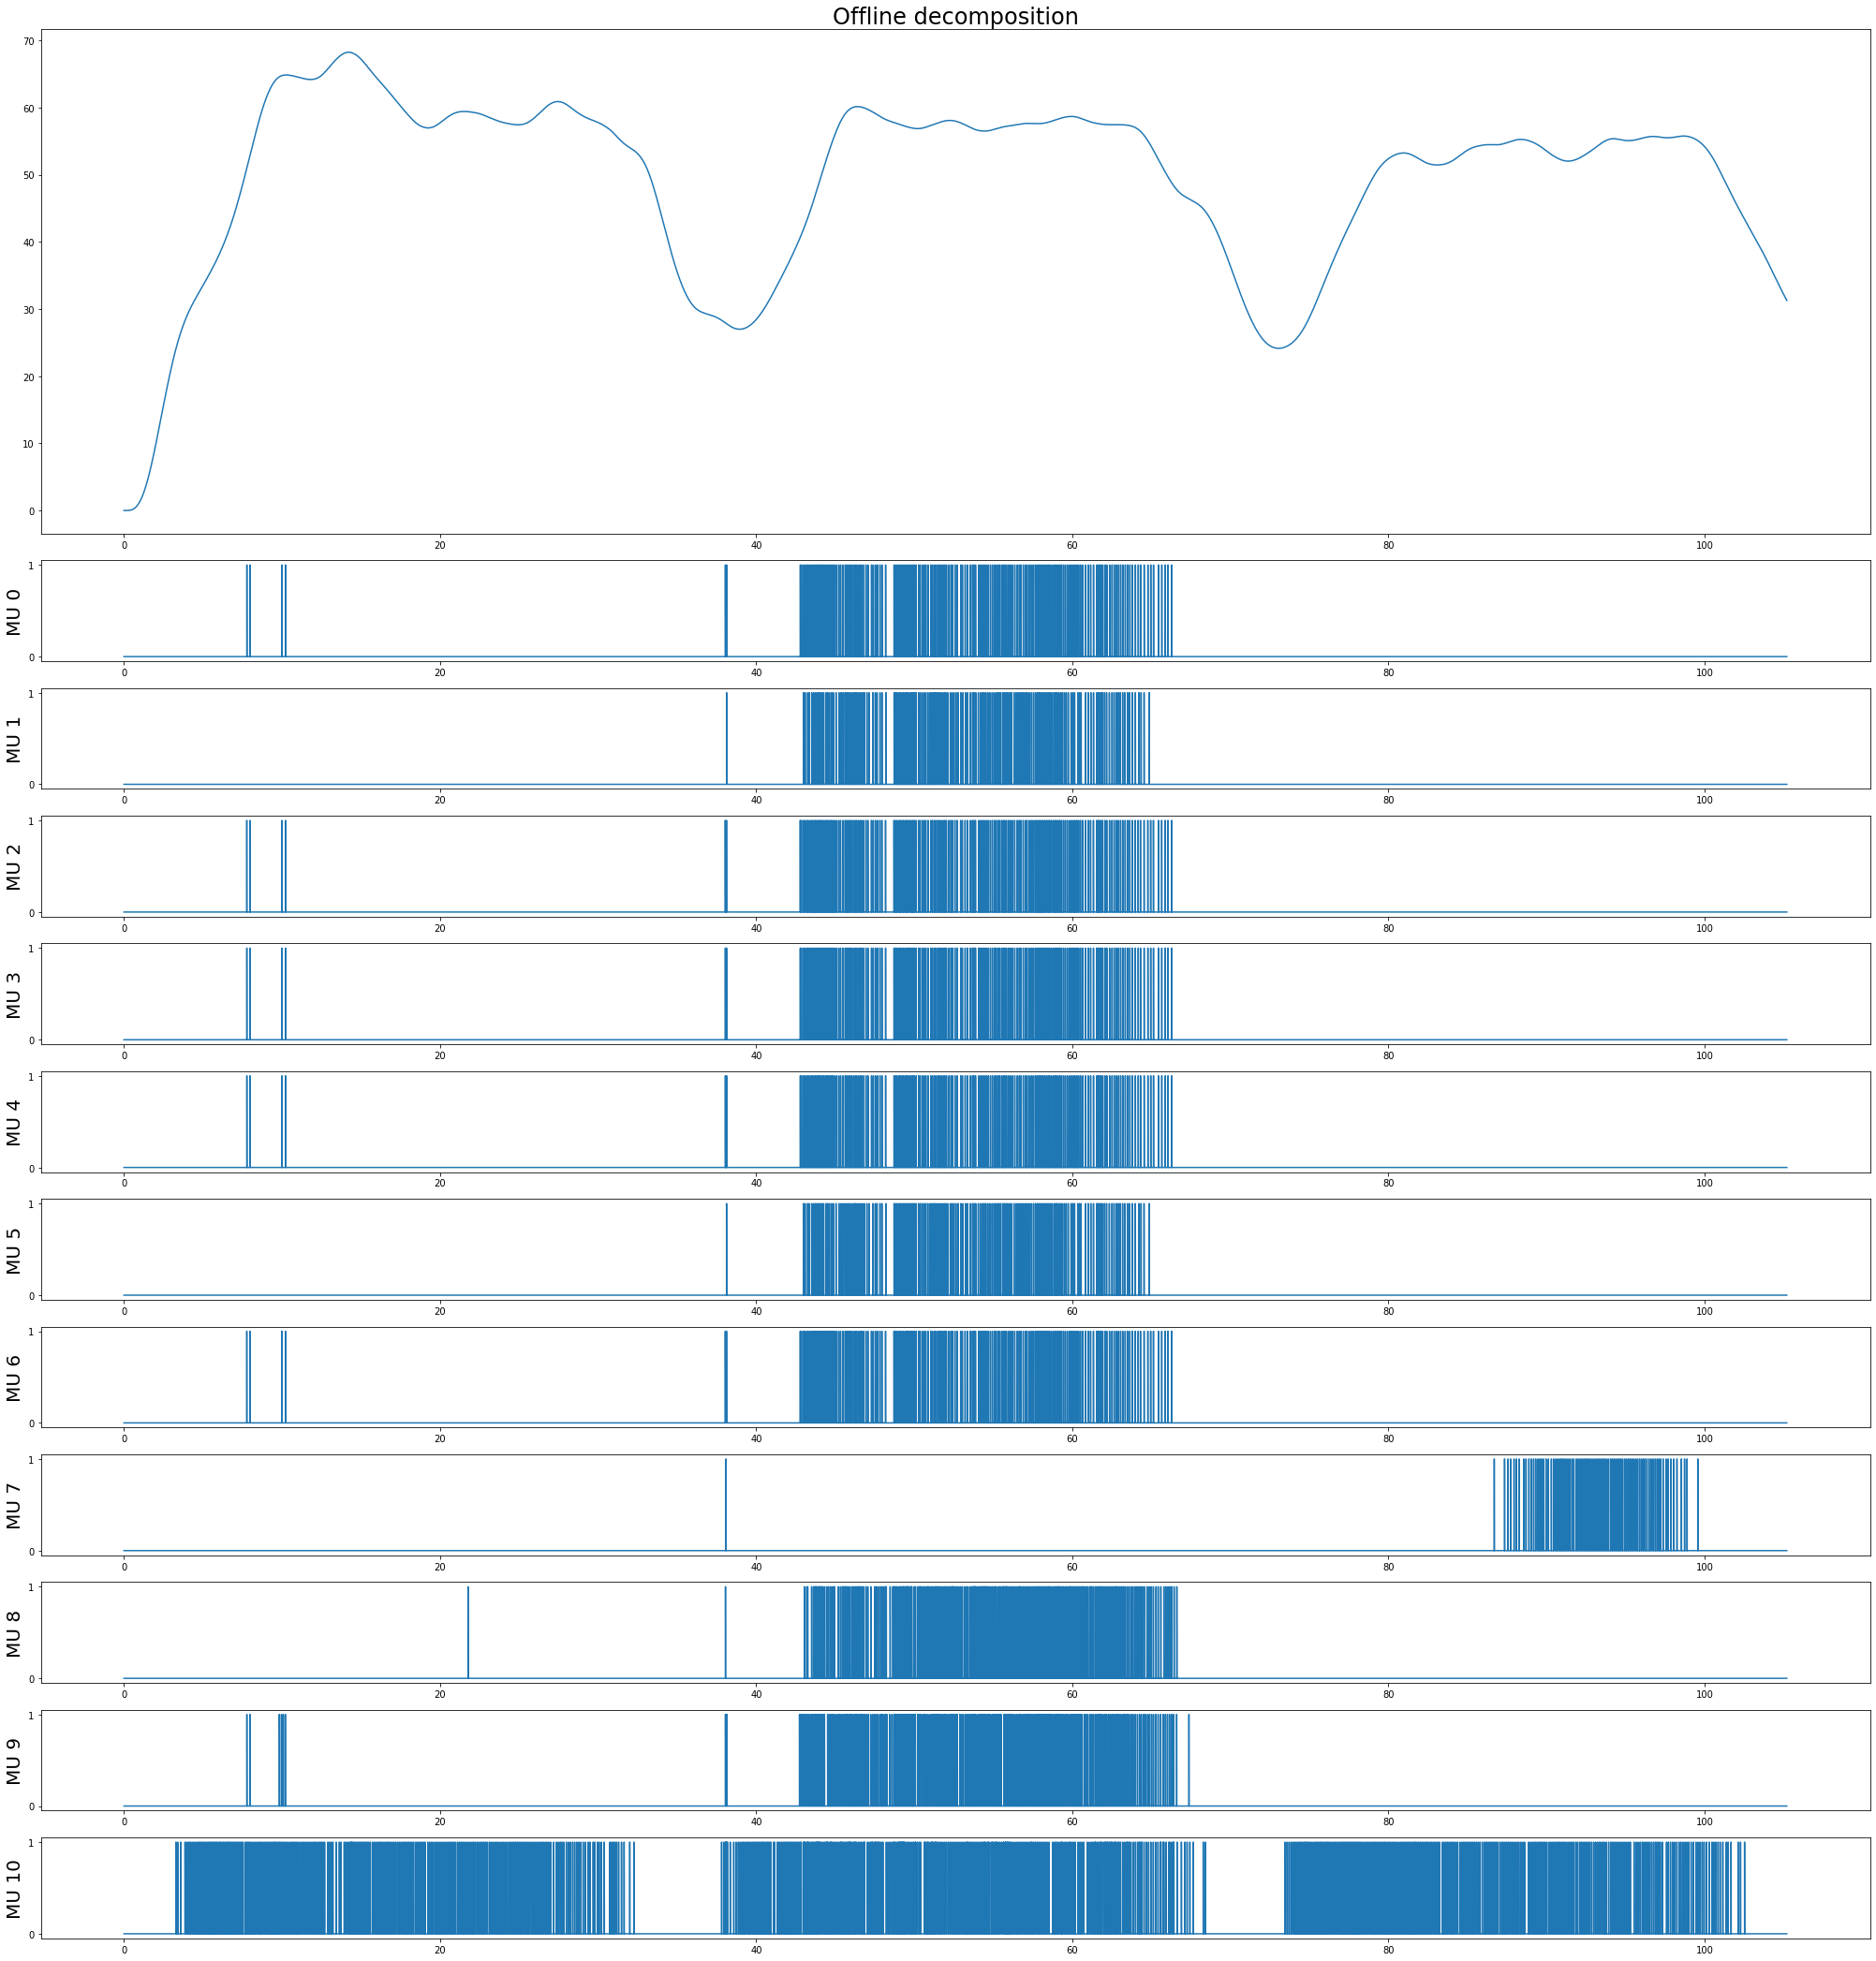

In [4]:
visualize_pt(decomp["MUPulses"], 
             data, title="Offline decomposition")

## ii. Separation matrix

In [4]:
# Realtime separation matrix
B = decomp["B"]
B_rt, mean_tm = sep_realtime(data, B, discard=bad_ch)

# Signal and noise centroids
signal_centroids_tm = decomp["peak_centroids"]
noise_centroids_tm = decomp["noise_centroids"]

# s^2 from the offline decomposition
s2_tm = np.square(decomp["s"])

# normalized signal and noise centroids (centroid / max(s^2))
sc_tm = []
nc_tm = []
for i in range(signal_centroids_tm.size):
    sc_tm.append(signal_centroids_tm[i] / signal_centroids_tm.max())
    nc_tm.append(noise_centroids_tm[i] / signal_centroids_tm.max())
sc_tm = np.array(sc_tm)
nc_tm = np.array(nc_tm)

# b. Decomposition module
## i. `kmeans_sil_cp_window`
### 4.0s, no overlap

In [24]:
kmeans_sil_cp_window_40 = batch_decomp_window(data, B_rt, mean_tm, discard = bad_ch, 
                                     use_kmeans=True, thd_noise=0.38, 
                                     classify_mu=False, 
                                     sil_dist=True, 
                                     thd_sil=0.9, 
                                     thd_pps=5,
                                     sc_tm=sc_tm, nc_tm=nc_tm, 
                                     batch_size=batch_size, overlap=0.0)

In [44]:
kmeans_sil_cp_window_40_pps10 = batch_decomp_window(data, B_rt, mean_tm, discard = bad_ch, 
                                     use_kmeans=True, thd_noise=0.38, 
                                     classify_mu=False, 
                                     sil_dist=True, 
                                     thd_sil=0.9, 
                                     thd_pps=10,
                                     sc_tm=sc_tm, nc_tm=nc_tm, 
                                     batch_size=batch_size, overlap=0.0)

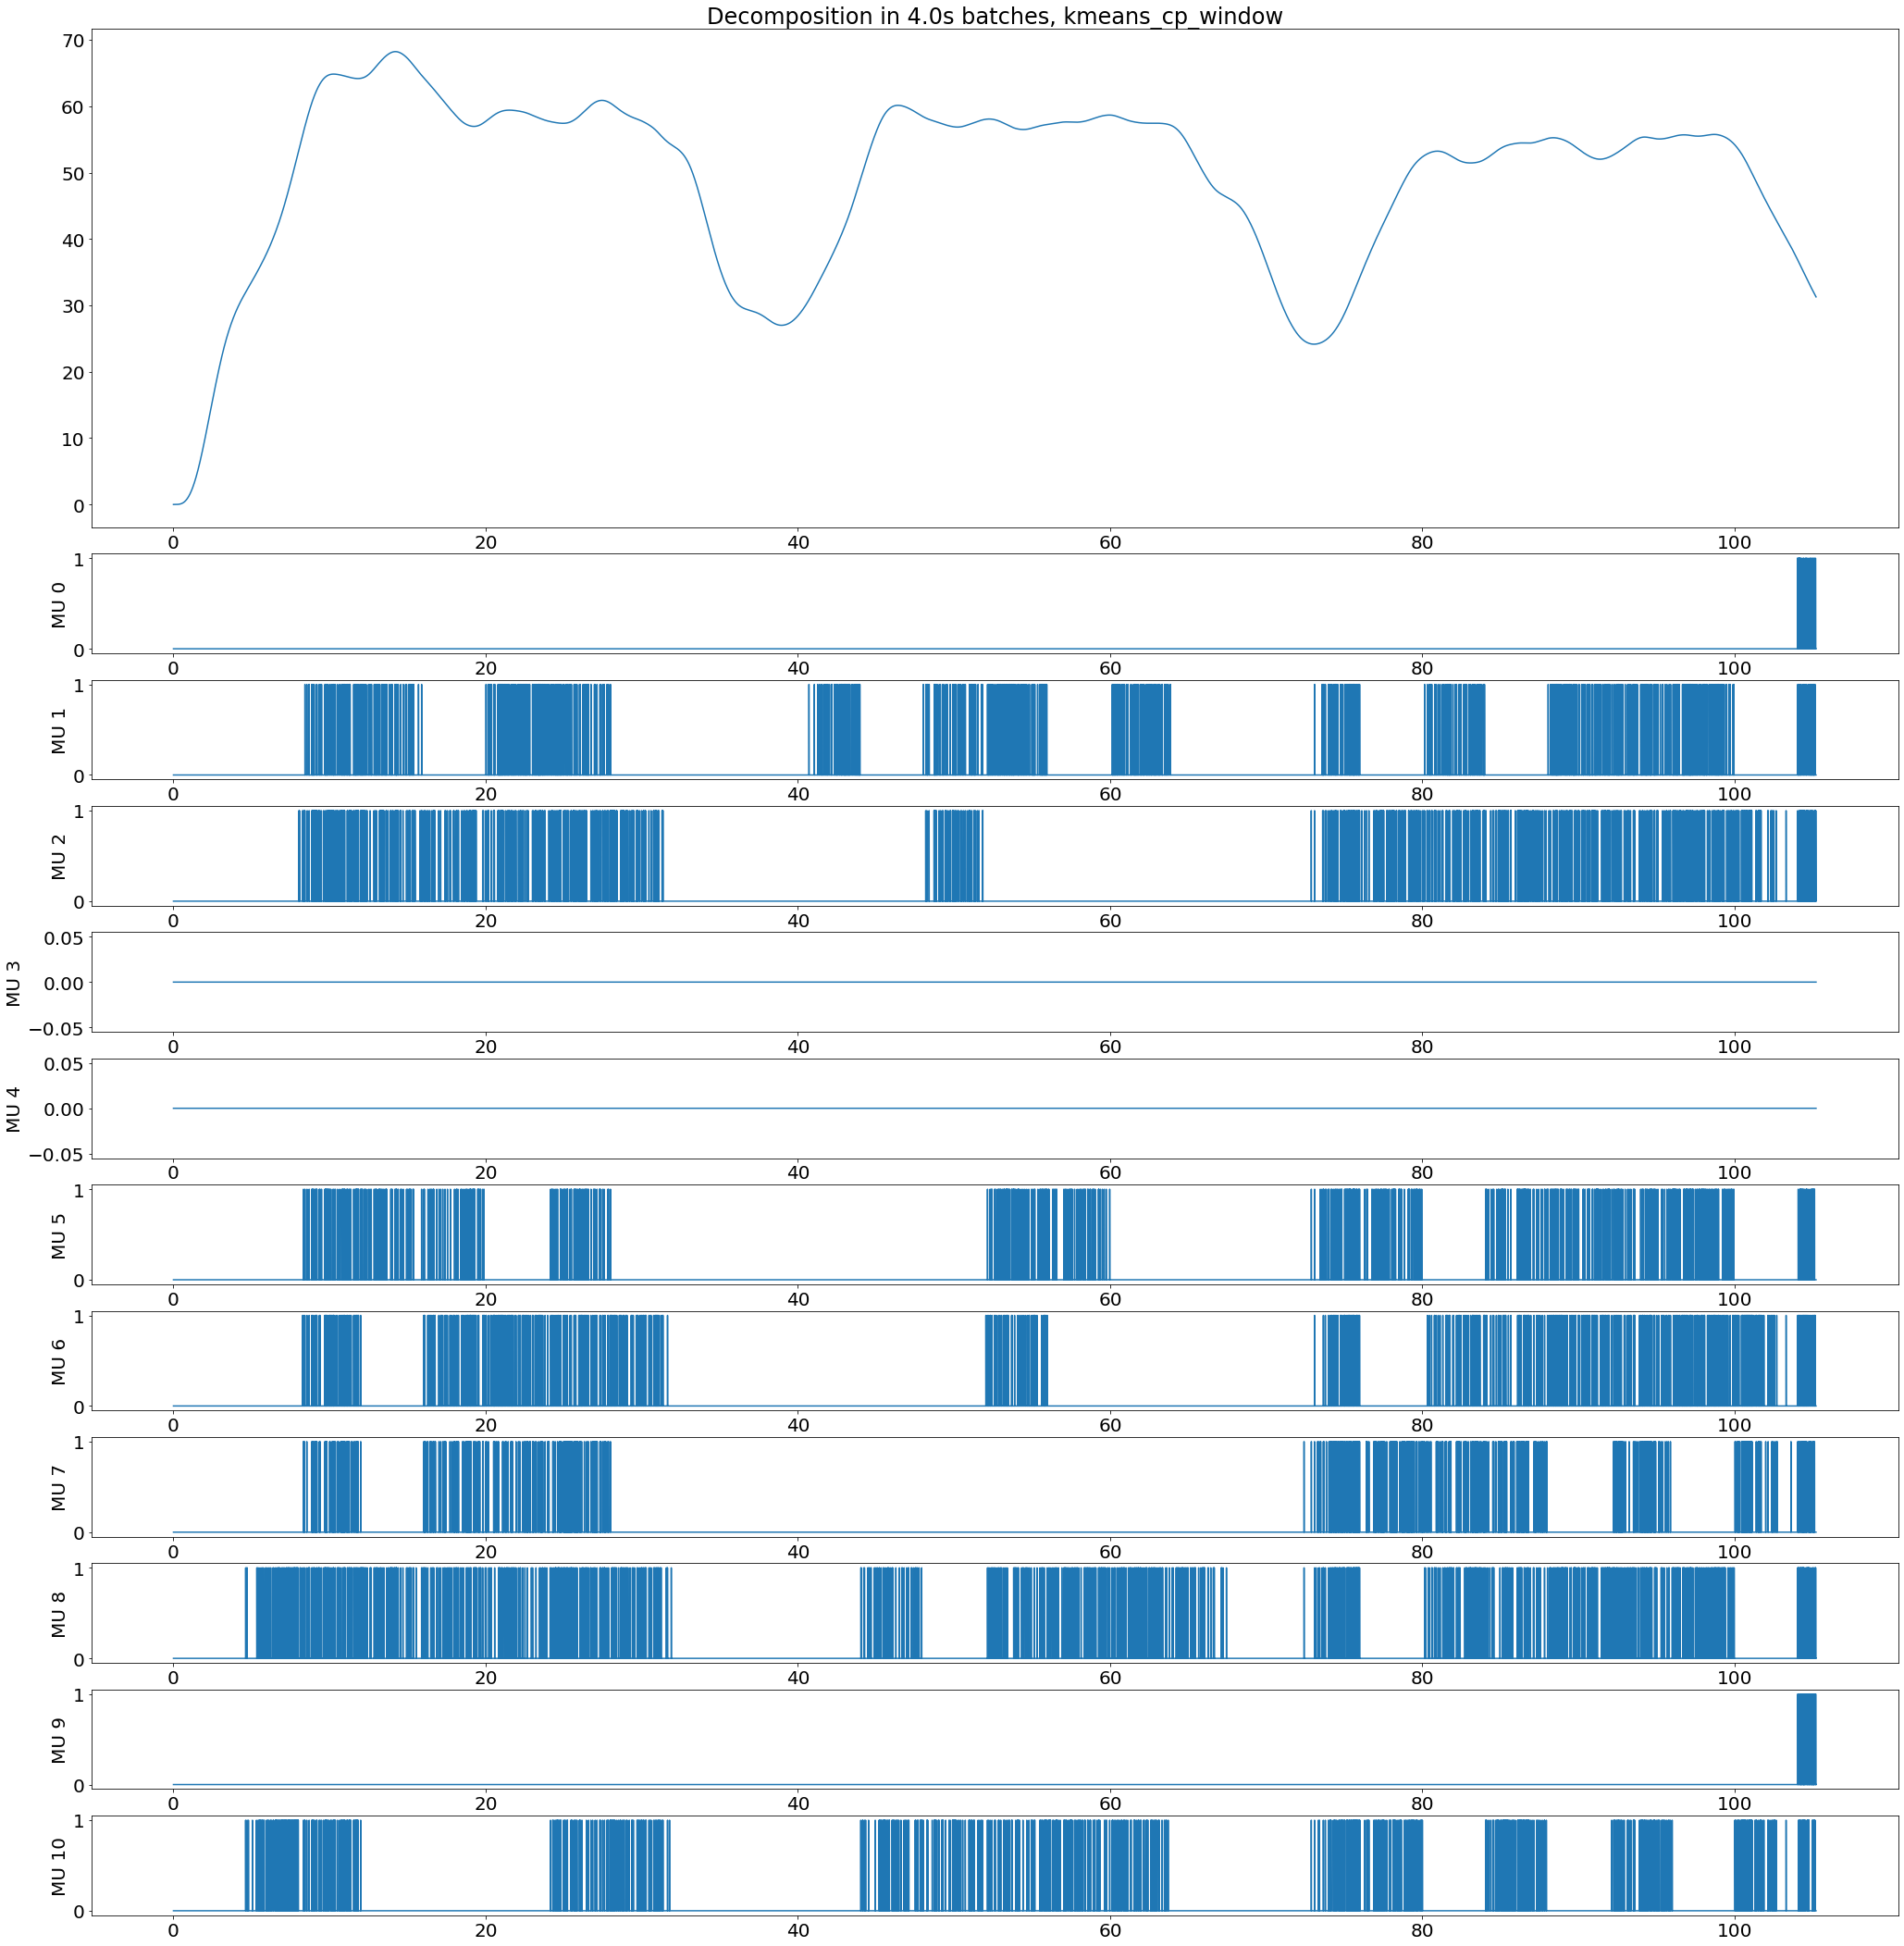

In [45]:
visualize_pt(kmeans_sil_cp_window_40_pps10["MUPulses"], 
             data, 
             title=f"Decomposition in {batch_size}s batches, kmeans_cp_window")

In [28]:
roa_kmeans_sil_cp_window_40 = calc_roa(ind_pt1=kmeans_sil_cp_window_40["MUPulses"], 
                                ind_pt2=decomp["MUPulses"], 
                                data=data, 
                                decomp=f"kmeans_cp_window {batch_size}s")

RoA between offline decomposition and kmeans_cp_window 4.0s (%):
Motor unit 0: 7.798165137614679
Motor unit 1: 2.6138279932546373
Motor unit 2: 8.651162790697674
Motor unit 3: 54.09090909090909
Motor unit 4: 49.28909952606635
Motor unit 5: 5.242334322453017
Motor unit 6: 10.467479674796747
Motor unit 7: 4.896142433234421
Motor unit 8: 6.471030850263356
Motor unit 9: 0.0
Motor unit 10: 2.275189599133261
mean: 13.79957649258393


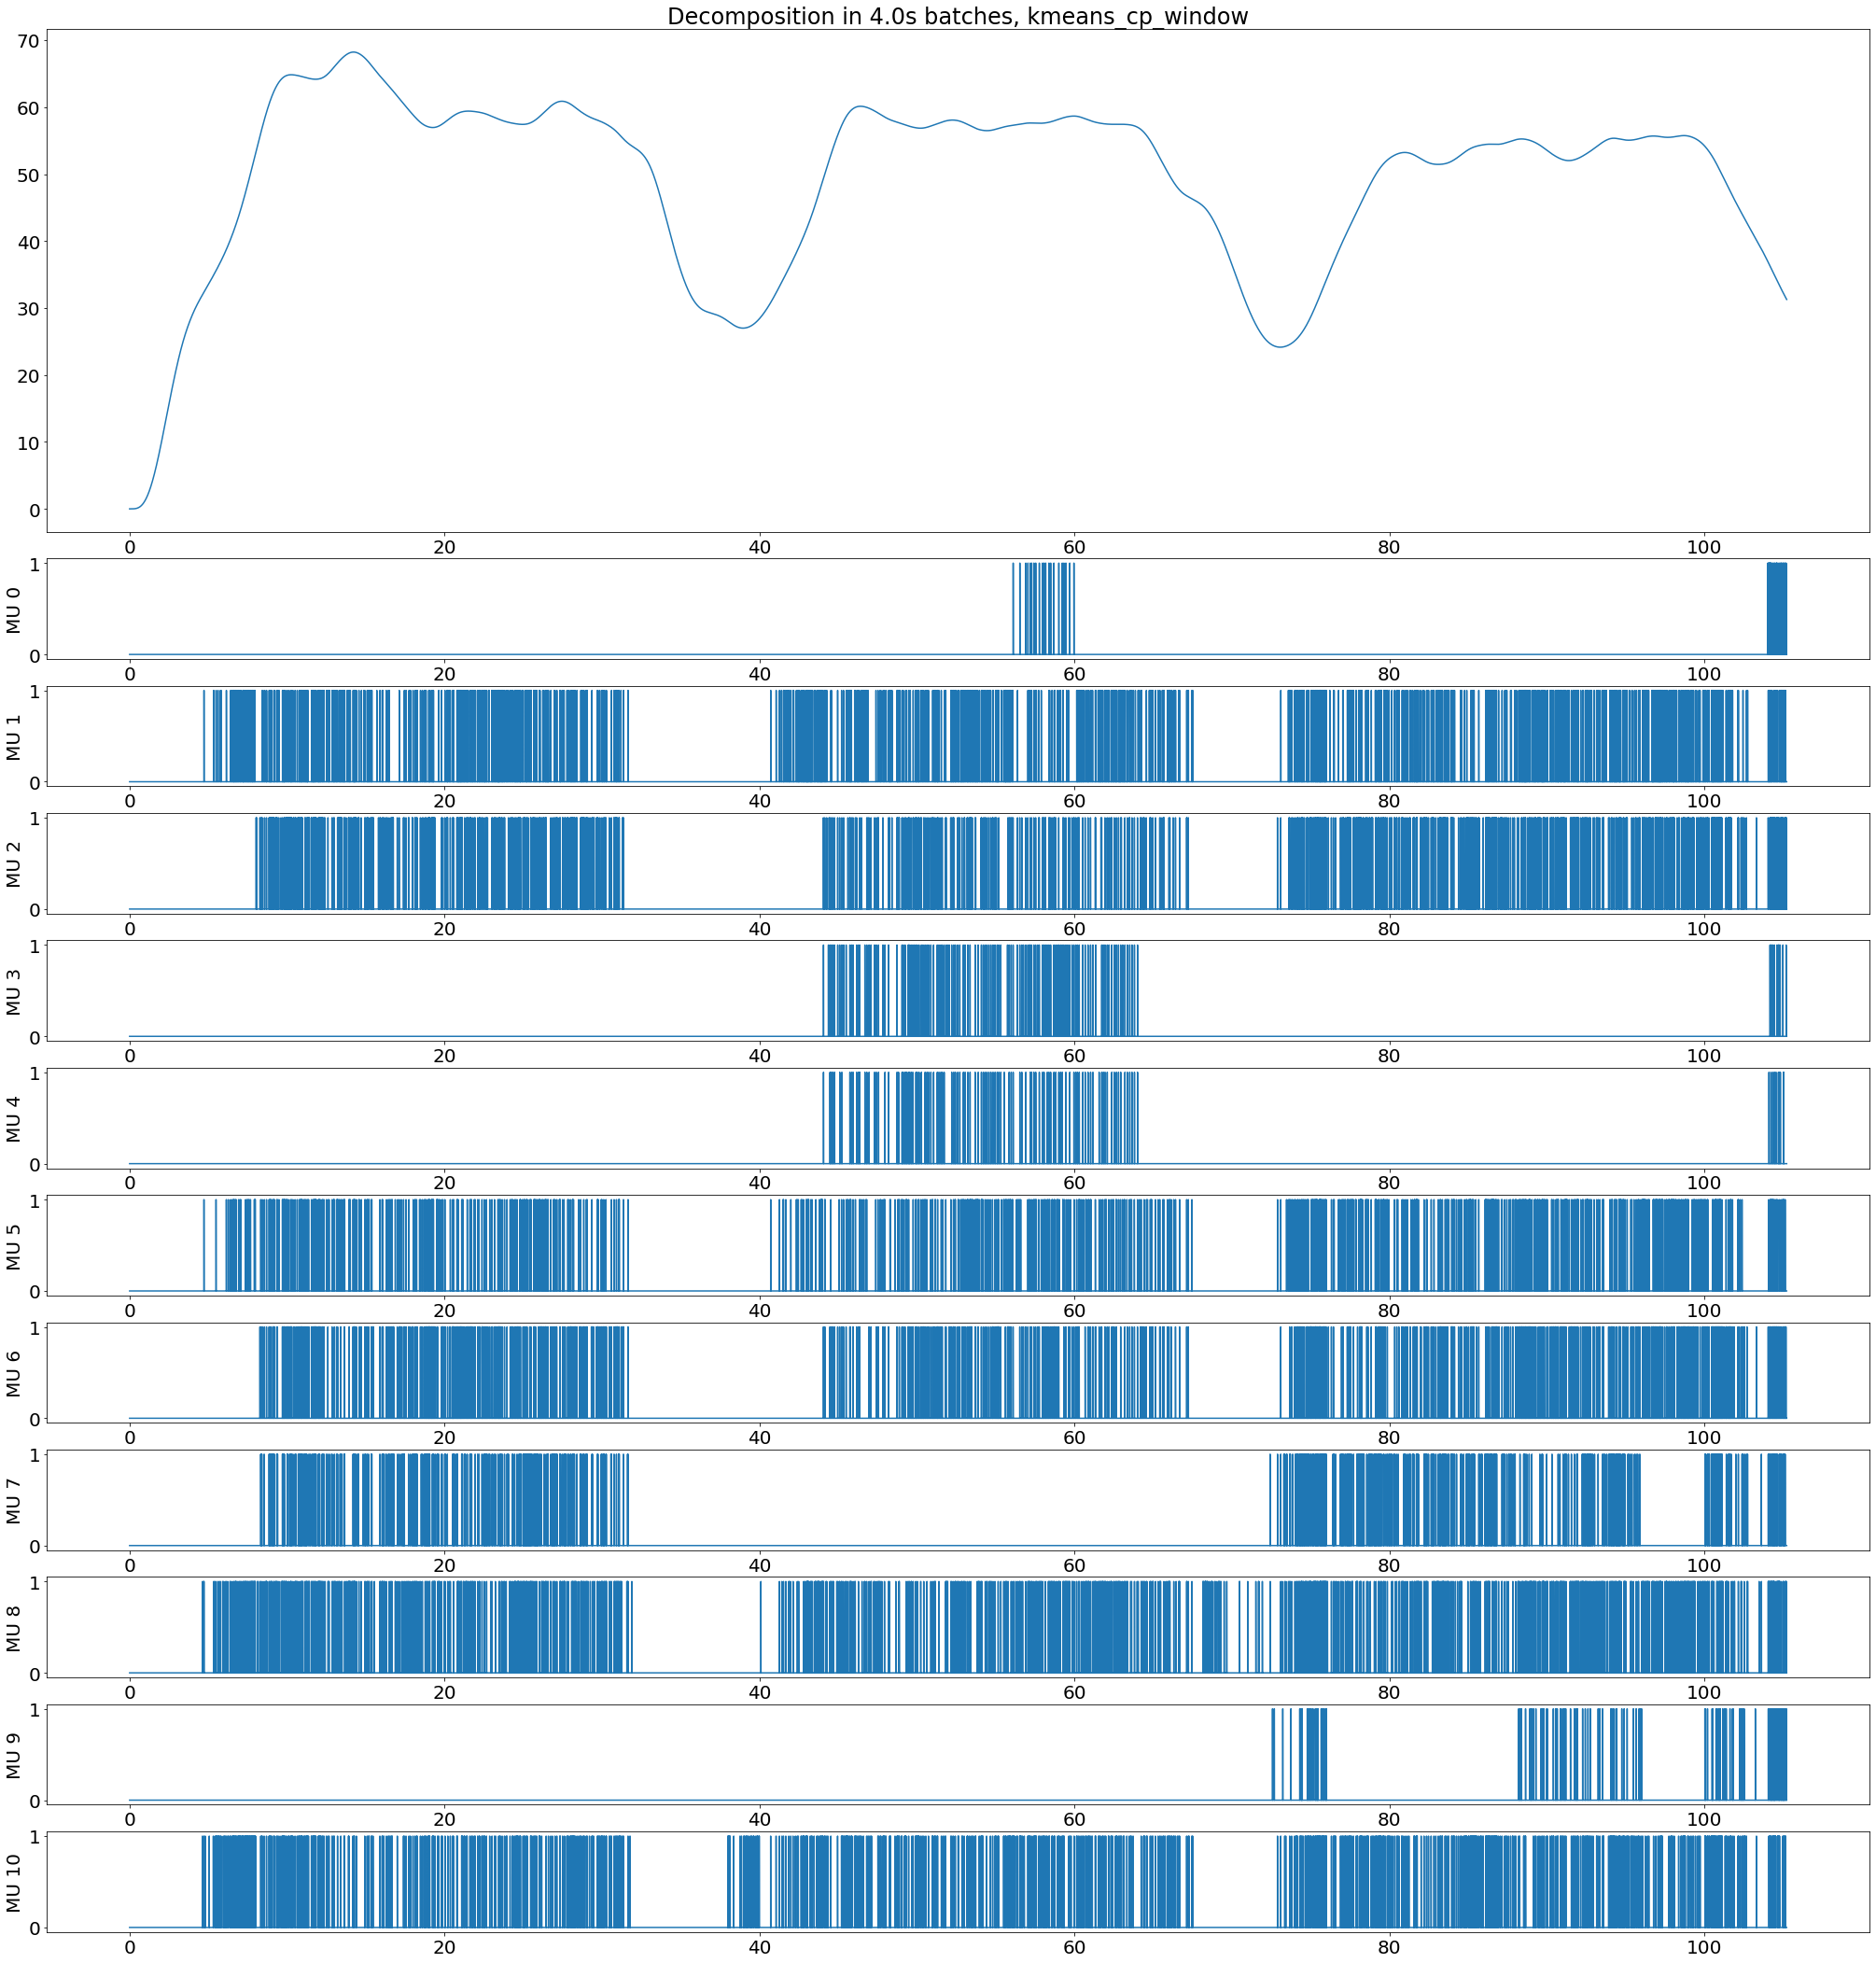

In [27]:
visualize_pt(kmeans_sil_cp_window_40["MUPulses"], 
             data, 
             title=f"Decomposition in {batch_size}s batches, kmeans_cp_window")

### 4.0s, 1.0s overlap

In [29]:
kmeans_sil_cp_window_40_ol10 = batch_decomp_window(data, B_rt, mean_tm, discard = bad_ch, 
                                     use_kmeans=True, thd_noise=0.38, 
                                     classify_mu=False, 
                                     sil_dist=True, 
                                     thd_sil=0.9, 
                                     thd_pps=5,
                                     sc_tm=sc_tm, nc_tm=nc_tm, 
                                     batch_size=batch_size, overlap=ol[0])

In [30]:
roa_kmeans_sil_cp_window_40_ol10 = calc_roa(ind_pt1=kmeans_sil_cp_window_40_ol10["MUPulses"], 
                                ind_pt2=decomp["MUPulses"], 
                                data=data, 
                                decomp=f"kmeans_cp_window {batch_size}s, overlap:{ol[0]}s")

RoA between offline decomposition and kmeans_cp_window 4.0s, overlap:1.0s (%):
Motor unit 0: 13.917525773195877
Motor unit 1: 2.8871391076115485
Motor unit 2: 8.795411089866157
Motor unit 3: 47.767857142857146
Motor unit 4: 47.524752475247524
Motor unit 5: 4.965243296921549
Motor unit 6: 10.114702815432743
Motor unit 7: 5.7663125948406675
Motor unit 8: 5.732946298984035
Motor unit 9: 0.0
Motor unit 10: 2.1881838074398248
mean: 13.605461309308827


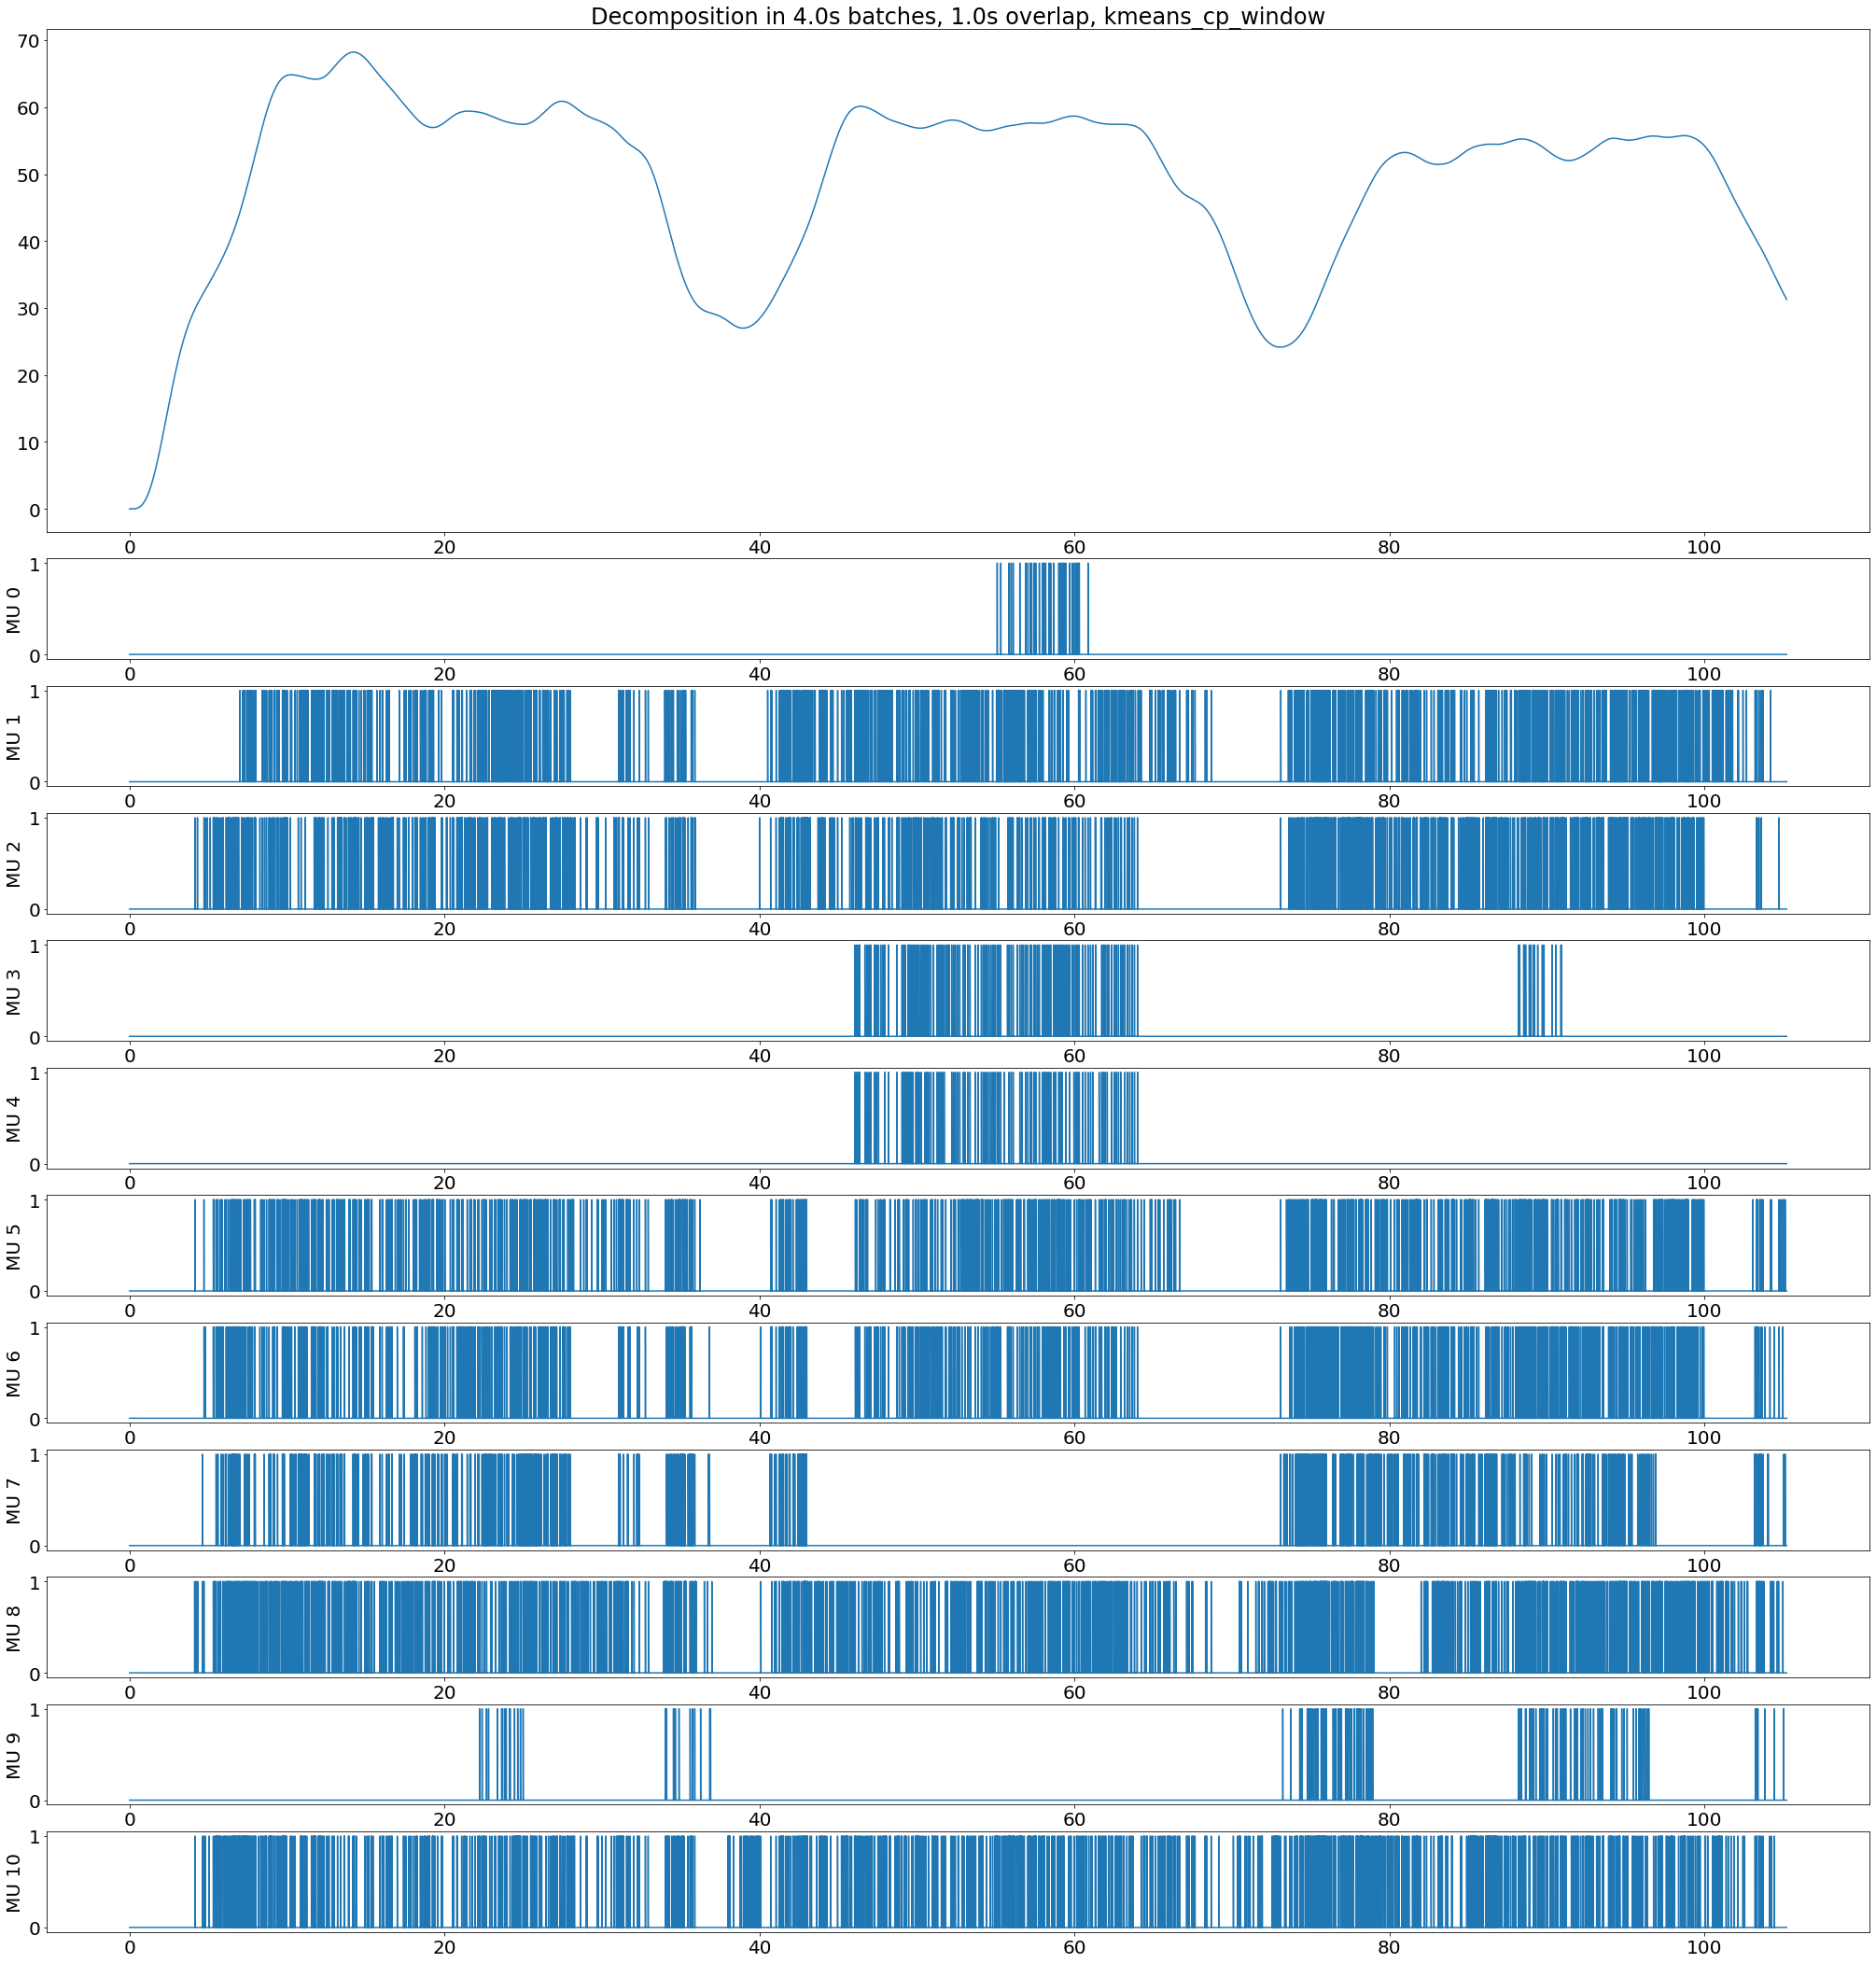

In [31]:
visualize_pt(kmeans_sil_cp_window_40_ol10["MUPulses"], 
             data, 
             title=f"Decomposition in {batch_size}s batches, {ol[0]}s overlap, kmeans_cp_window")

### 4.0s, 2.0s overlap

In [36]:
kmeans_sil_cp_window_40_ol20 = batch_decomp_window(data, B_rt, mean_tm, discard = bad_ch, 
                                     use_kmeans=True, thd_noise=0.38, 
                                     classify_mu=False, 
                                     sil_dist=True, 
                                     thd_sil=0.9, 
                                     thd_pps=5,
                                     sc_tm=sc_tm, nc_tm=nc_tm, 
                                     batch_size=batch_size, overlap=ol[1])

In [37]:
roa_kmeans_sil_cp_window_40_ol20 = calc_roa(ind_pt1=kmeans_sil_cp_window_40_ol20["MUPulses"], 
                                ind_pt2=decomp["MUPulses"], 
                                data=data, 
                                decomp=f"kmeans_cp_window {batch_size}s, overlap:{ol[1]}s")

RoA between offline decomposition and kmeans_cp_window 4.0s, overlap:2.0s (%):
Motor unit 0: 11.961722488038278
Motor unit 1: 2.607232968881413
Motor unit 2: 8.679245283018869
Motor unit 3: 52.31481481481482
Motor unit 4: 46.766169154228855
Motor unit 5: 5.236139630390143
Motor unit 6: 10.084033613445378
Motor unit 7: 6.4275037369207775
Motor unit 8: 6.298003072196621
Motor unit 9: 0.0
Motor unit 10: 2.255225522552255
mean: 13.875462753135219


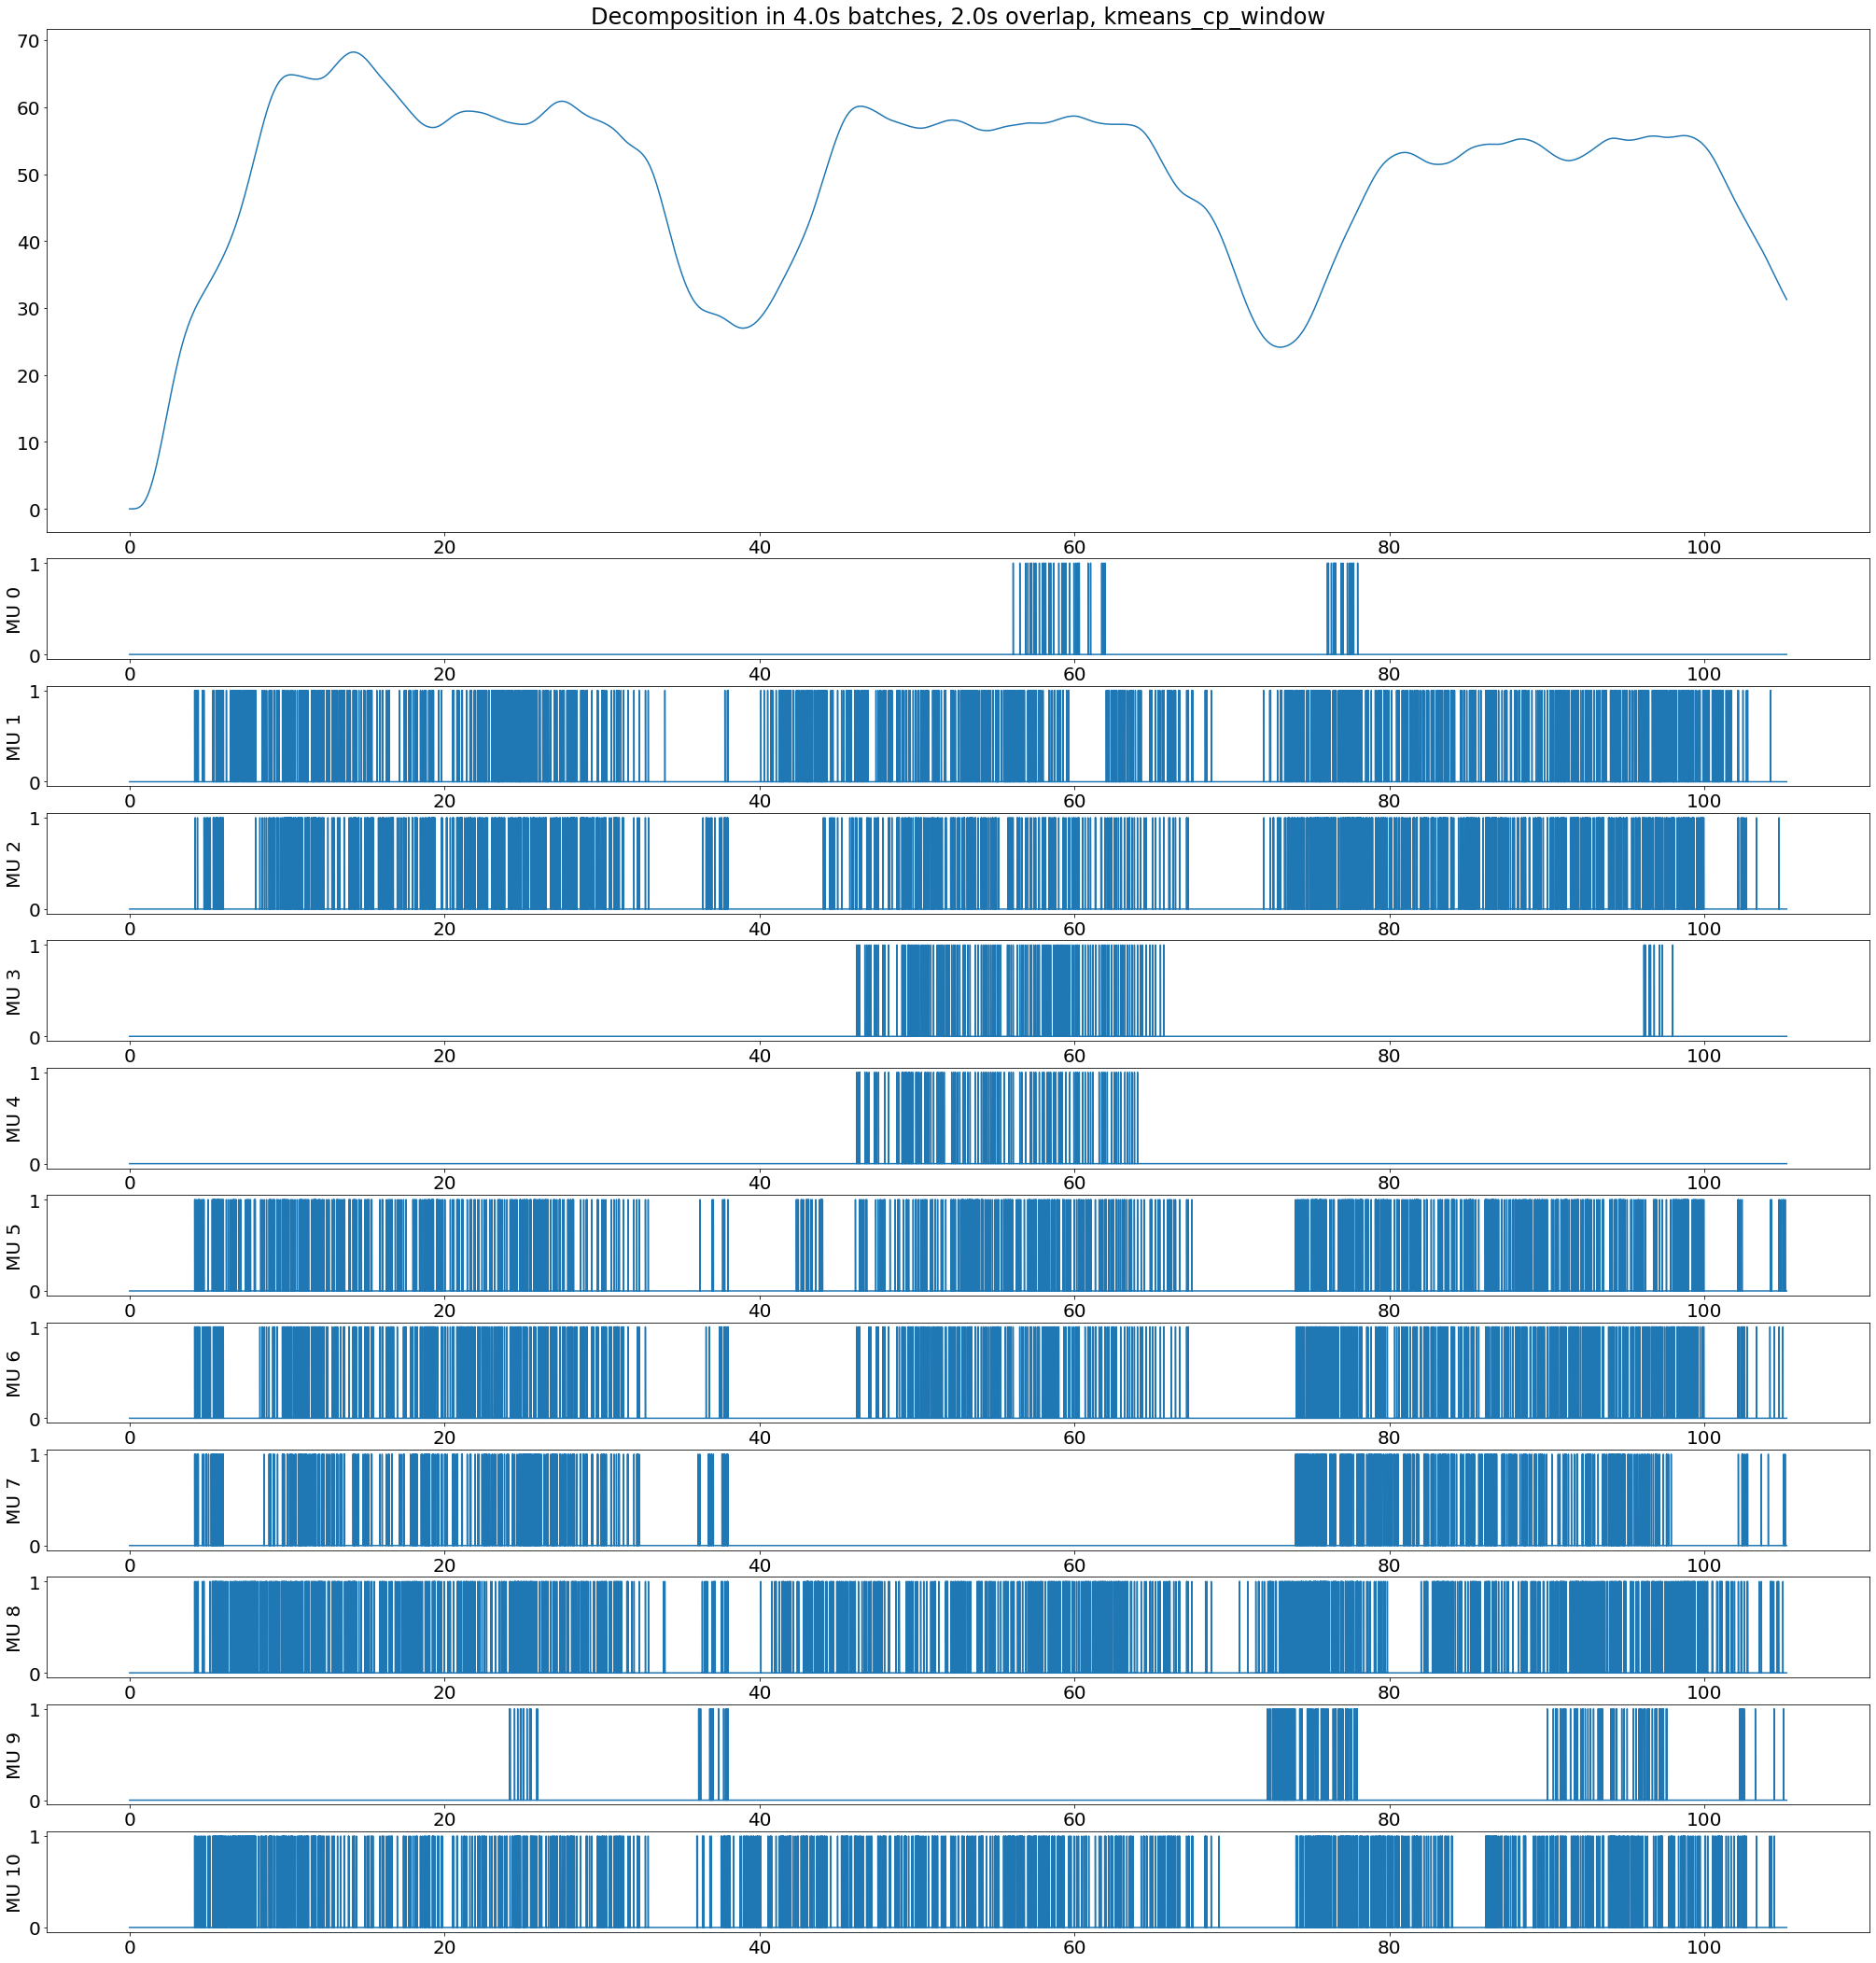

In [38]:
visualize_pt(kmeans_sil_cp_window_40_ol20["MUPulses"], 
             data, 
             title=f"Decomposition in {batch_size}s batches, {ol[1]}s overlap, kmeans_cp_window")

### 4.0s, 3.0s overlap

In [39]:
kmeans_sil_cp_40_ol30 = batch_decomp_window(data, B_rt, mean_tm, discard = bad_ch, 
                                     use_kmeans=True, thd_noise=0.38, 
                                     classify_mu=False, 
                                     sil_dist=True, 
                                     thd_sil=0.9,
                                     thd_pps=5, 
                                     sc_tm=sc_tm, nc_tm=nc_tm, 
                                     batch_size=batch_size, overlap=ol[2])

In [42]:
roa_kmeans_sil_cp_40_ol30 = calc_roa(ind_pt1=kmeans_sil_cp_40_ol30["MUPulses"], 
                                    ind_pt2=decomp["MUPulses"], 
                                    data=data, 
                                    decomp=f"kmeans_cp_window {batch_size}s, overlap:{ol[2]}s")

RoA between offline decomposition and kmeans_cp_window 4.0s, overlap:3.0s (%):
Motor unit 0: 12.807881773399014
Motor unit 1: 2.780191138140747
Motor unit 2: 7.670720299345183
Motor unit 3: 52.33644859813084
Motor unit 4: 45.77114427860697
Motor unit 5: 5.413687436159346
Motor unit 6: 10.030706243602866
Motor unit 7: 6.515580736543909
Motor unit 8: 6.150341685649202
Motor unit 9: 0.0
Motor unit 10: 2.355460385438972
mean: 13.802923870456095


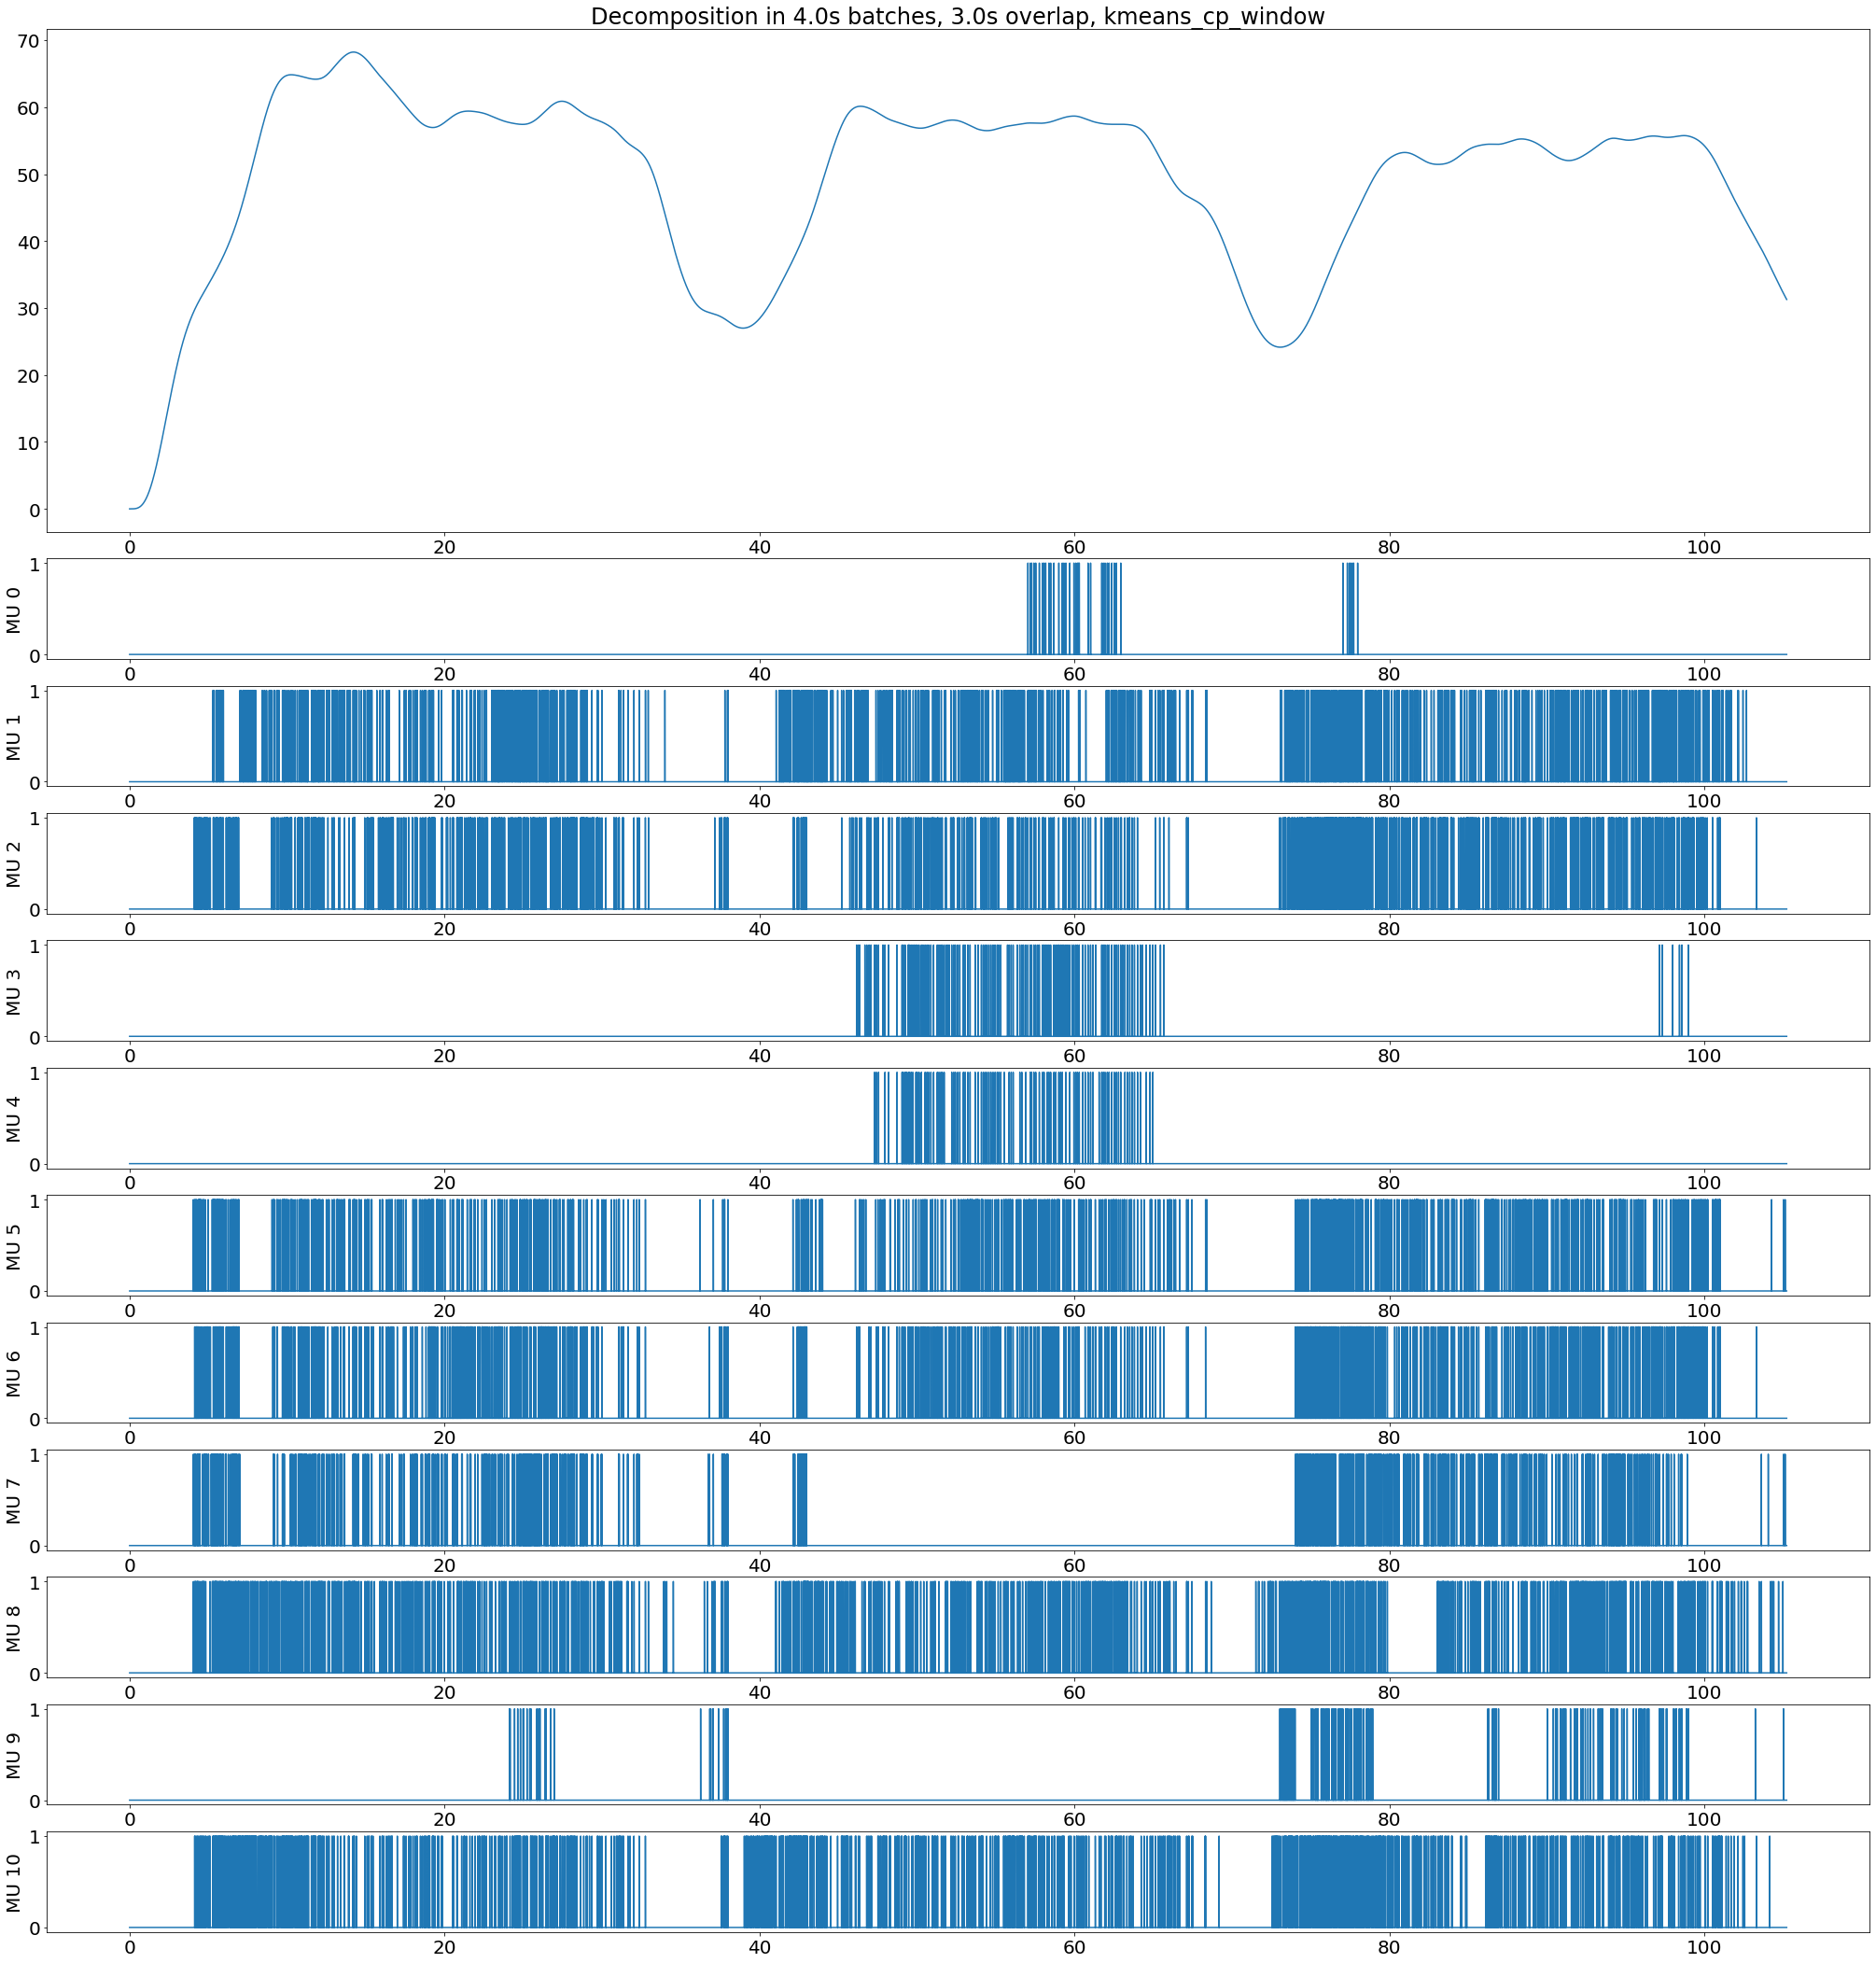

In [43]:
visualize_pt(kmeans_sil_cp_40_ol30["MUPulses"], 
             data, 
             title=f"Decomposition in {batch_size}s batches, {ol[2]}s overlap, kmeans_cp_window")

## ii. `kmeans_cp_sil`
### 4.0s, no overlap

In [17]:
kmeans_cp_sil_40 = batch_decomp2(data, B_rt, mean_tm, discard = bad_ch, 
                                use_kmeans=True, thd_noise=0.38, 
                                classify_mu=True, 
                                sil_dist=True, 
                                thd_sil=0.9, 
                                sc_tm=sc_tm, nc_tm=nc_tm, 
                                batch_size=batch_size, overlap=0.0)

In [18]:
roa_kmeans_cp_sil_40 = calc_roa(ind_pt1=kmeans_cp_sil_40["MUPulses"], 
                                ind_pt2=decomp["MUPulses"], 
                                data=data, 
                                decomp=f"kmeans_cp_sil {batch_size}s")

RoA between offline decomposition and kmeans_cp_sil 4.0s (%):
Motor unit 0: 25.502008032128515
Motor unit 1: 1.4814814814814814
Motor unit 2: 16.36085626911315
Motor unit 3: 33.333333333333336
Motor unit 4: 33.77483443708609
Motor unit 5: 7.054673721340388
Motor unit 6: 17.792421746293247
Motor unit 7: 8.653846153846153
Motor unit 8: 16.602316602316602
Motor unit 9: 19.736842105263158
Motor unit 10: 1.9607843137254901
mean: 16.56849074508433


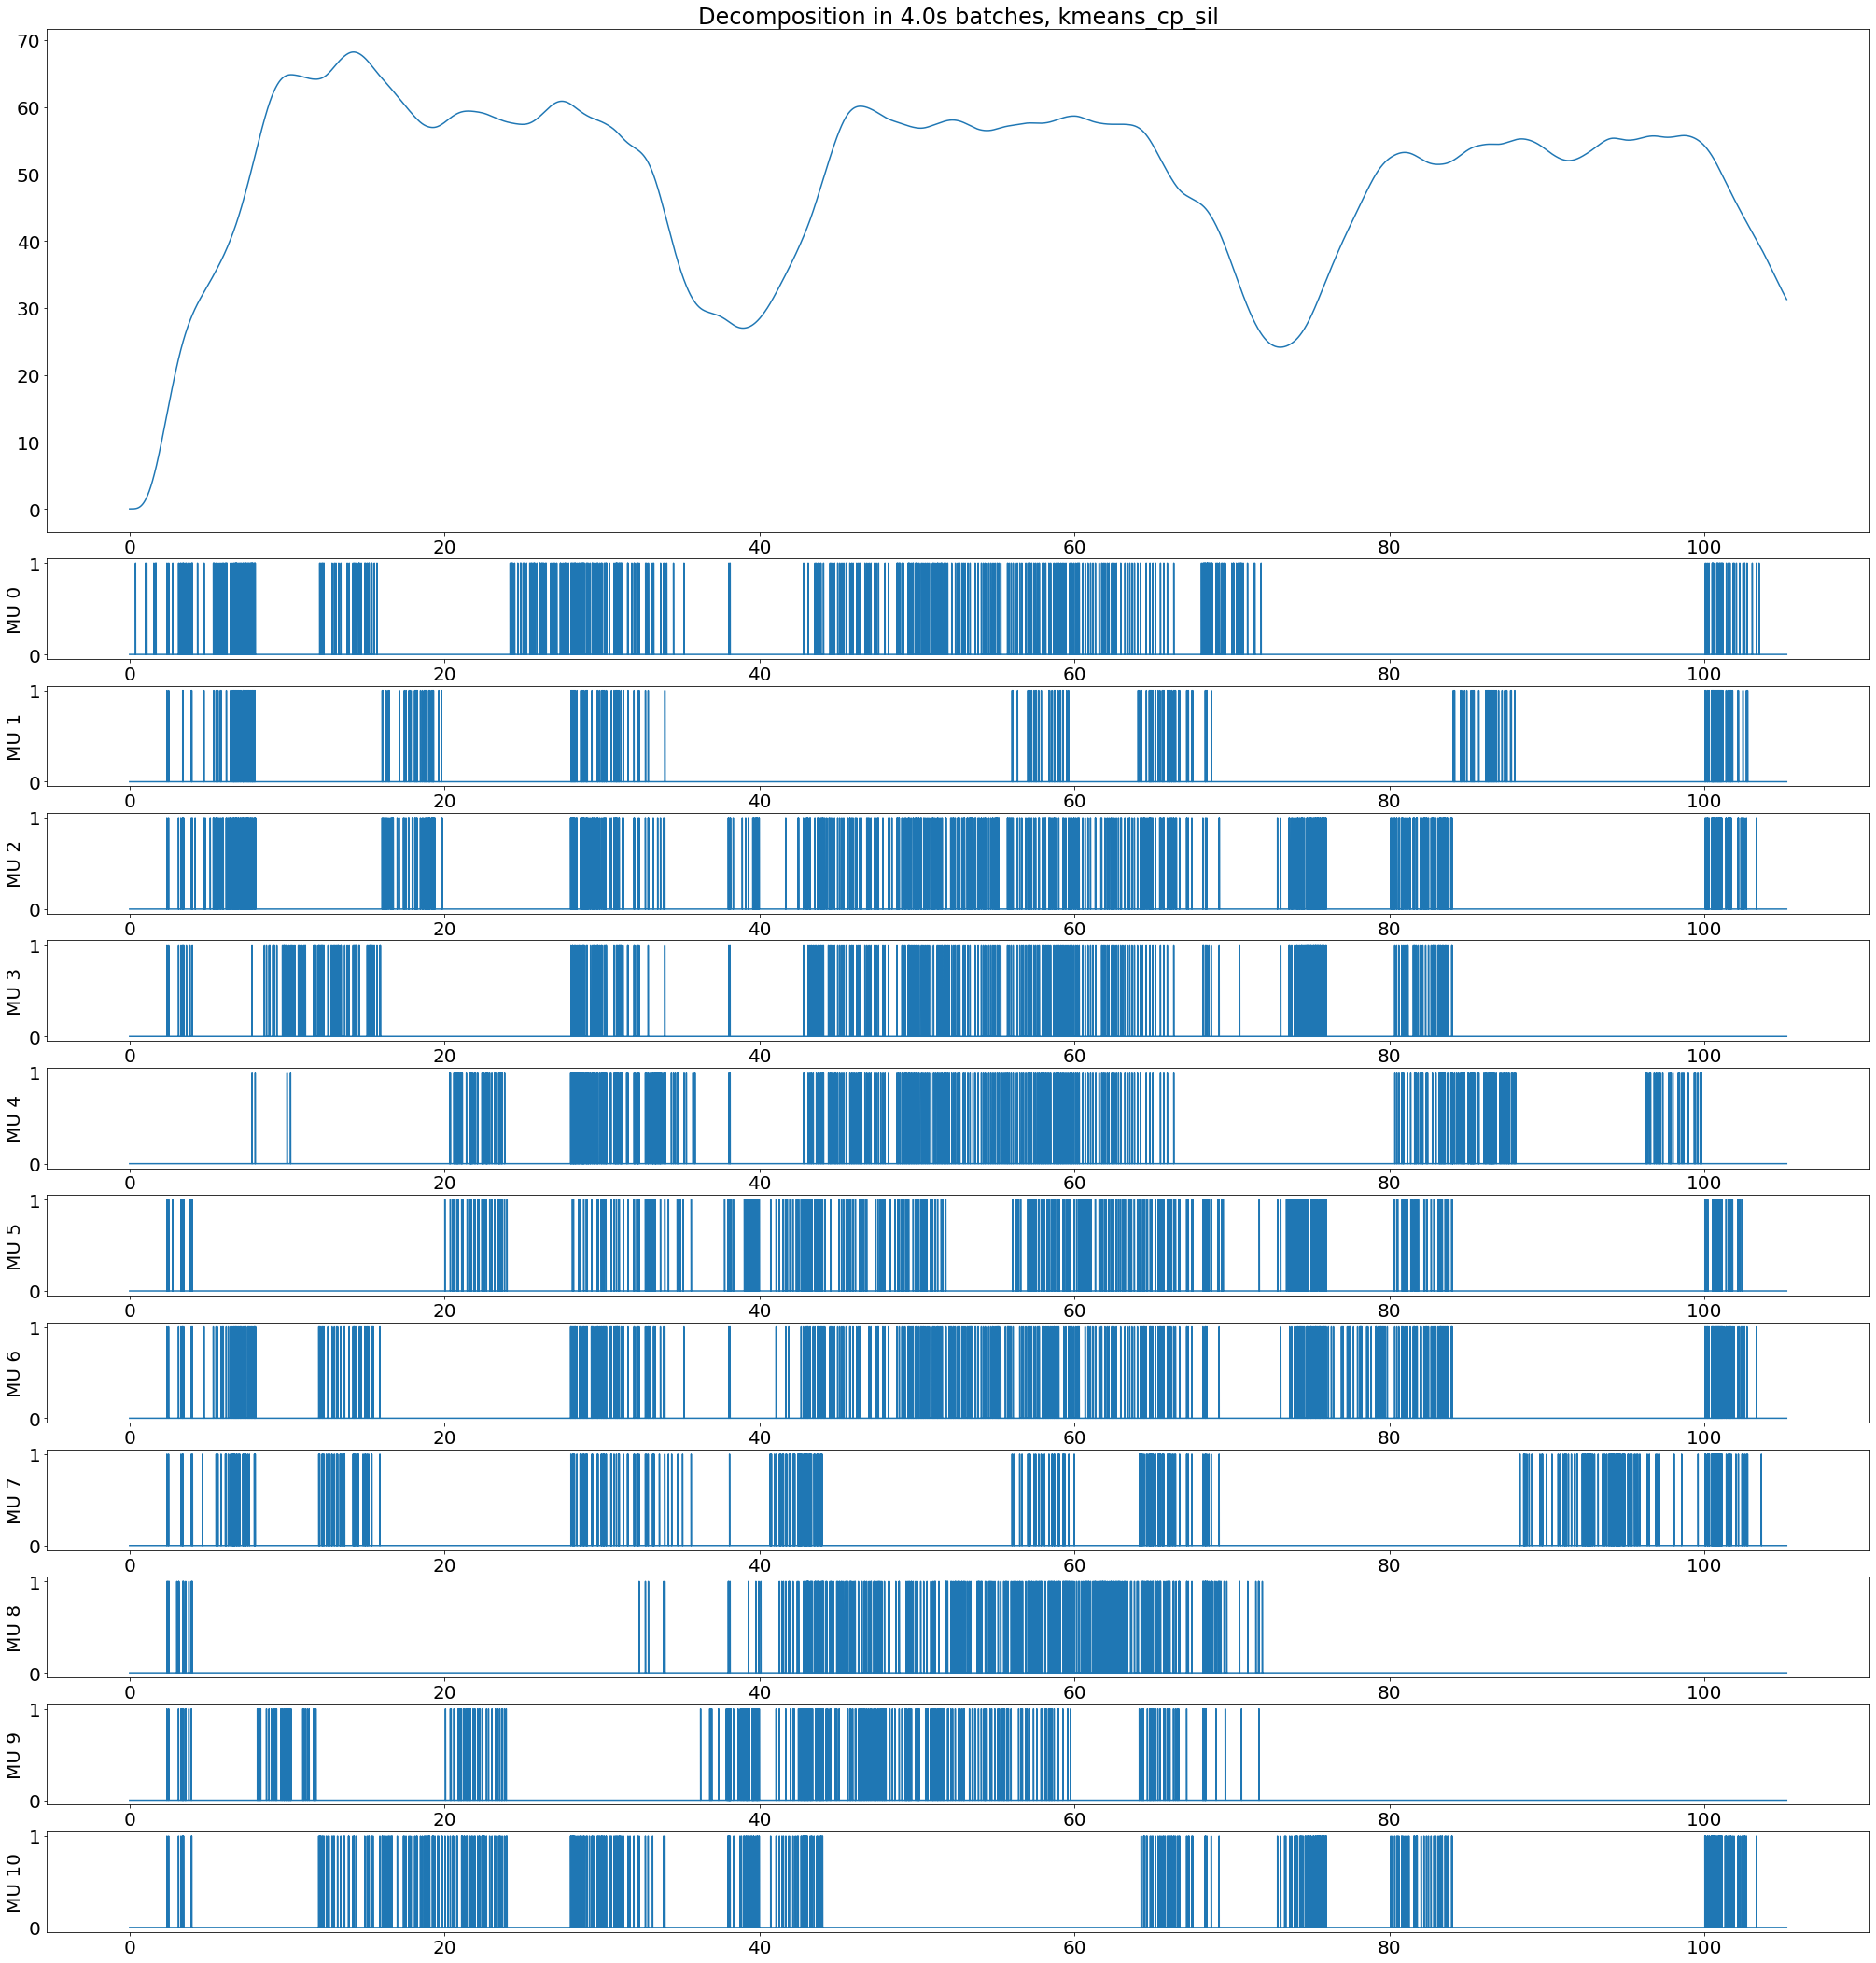

In [19]:
visualize_pt(kmeans_cp_sil_40["MUPulses"], 
             data, 
             title=f"Decomposition in {batch_size}s batches, kmeans_cp_sil")

### 4.0s, 1.0s overlap

In [20]:
kmeans_cp_sil_40_ol10 = batch_decomp2(data, B_rt, mean_tm, discard = bad_ch, 
                                     use_kmeans=True, thd_noise=0.38, 
                                     classify_mu=True, 
                                     sil_dist=True, 
                                     thd_sil=0.9, 
                                     sc_tm=sc_tm, nc_tm=nc_tm, 
                                     batch_size=batch_size, overlap=ol[0])

In [21]:
roa_kmeans_cp_sil_40_ol10 = calc_roa(ind_pt1=kmeans_cp_sil_40_ol10["MUPulses"], 
                                    ind_pt2=decomp["MUPulses"], 
                                    data=data, 
                                    decomp=f"kmeans_cp_sil {batch_size}s, overlap:{ol[0]}s")

RoA between offline decomposition and kmeans_cp_sil 4.0s, overlap:1.0s (%):
Motor unit 0: 26.048565121412803
Motor unit 1: 0.9433962264150944
Motor unit 2: 14.93411420204978
Motor unit 3: 33.021077283372364
Motor unit 4: 31.589958158995817
Motor unit 5: 8.704453441295547
Motor unit 6: 20.48872180451128
Motor unit 7: 11.436950146627566
Motor unit 8: 14.76091476091476
Motor unit 9: 18.476190476190474
Motor unit 10: 1.8563357546408394
mean: 16.569152488766033


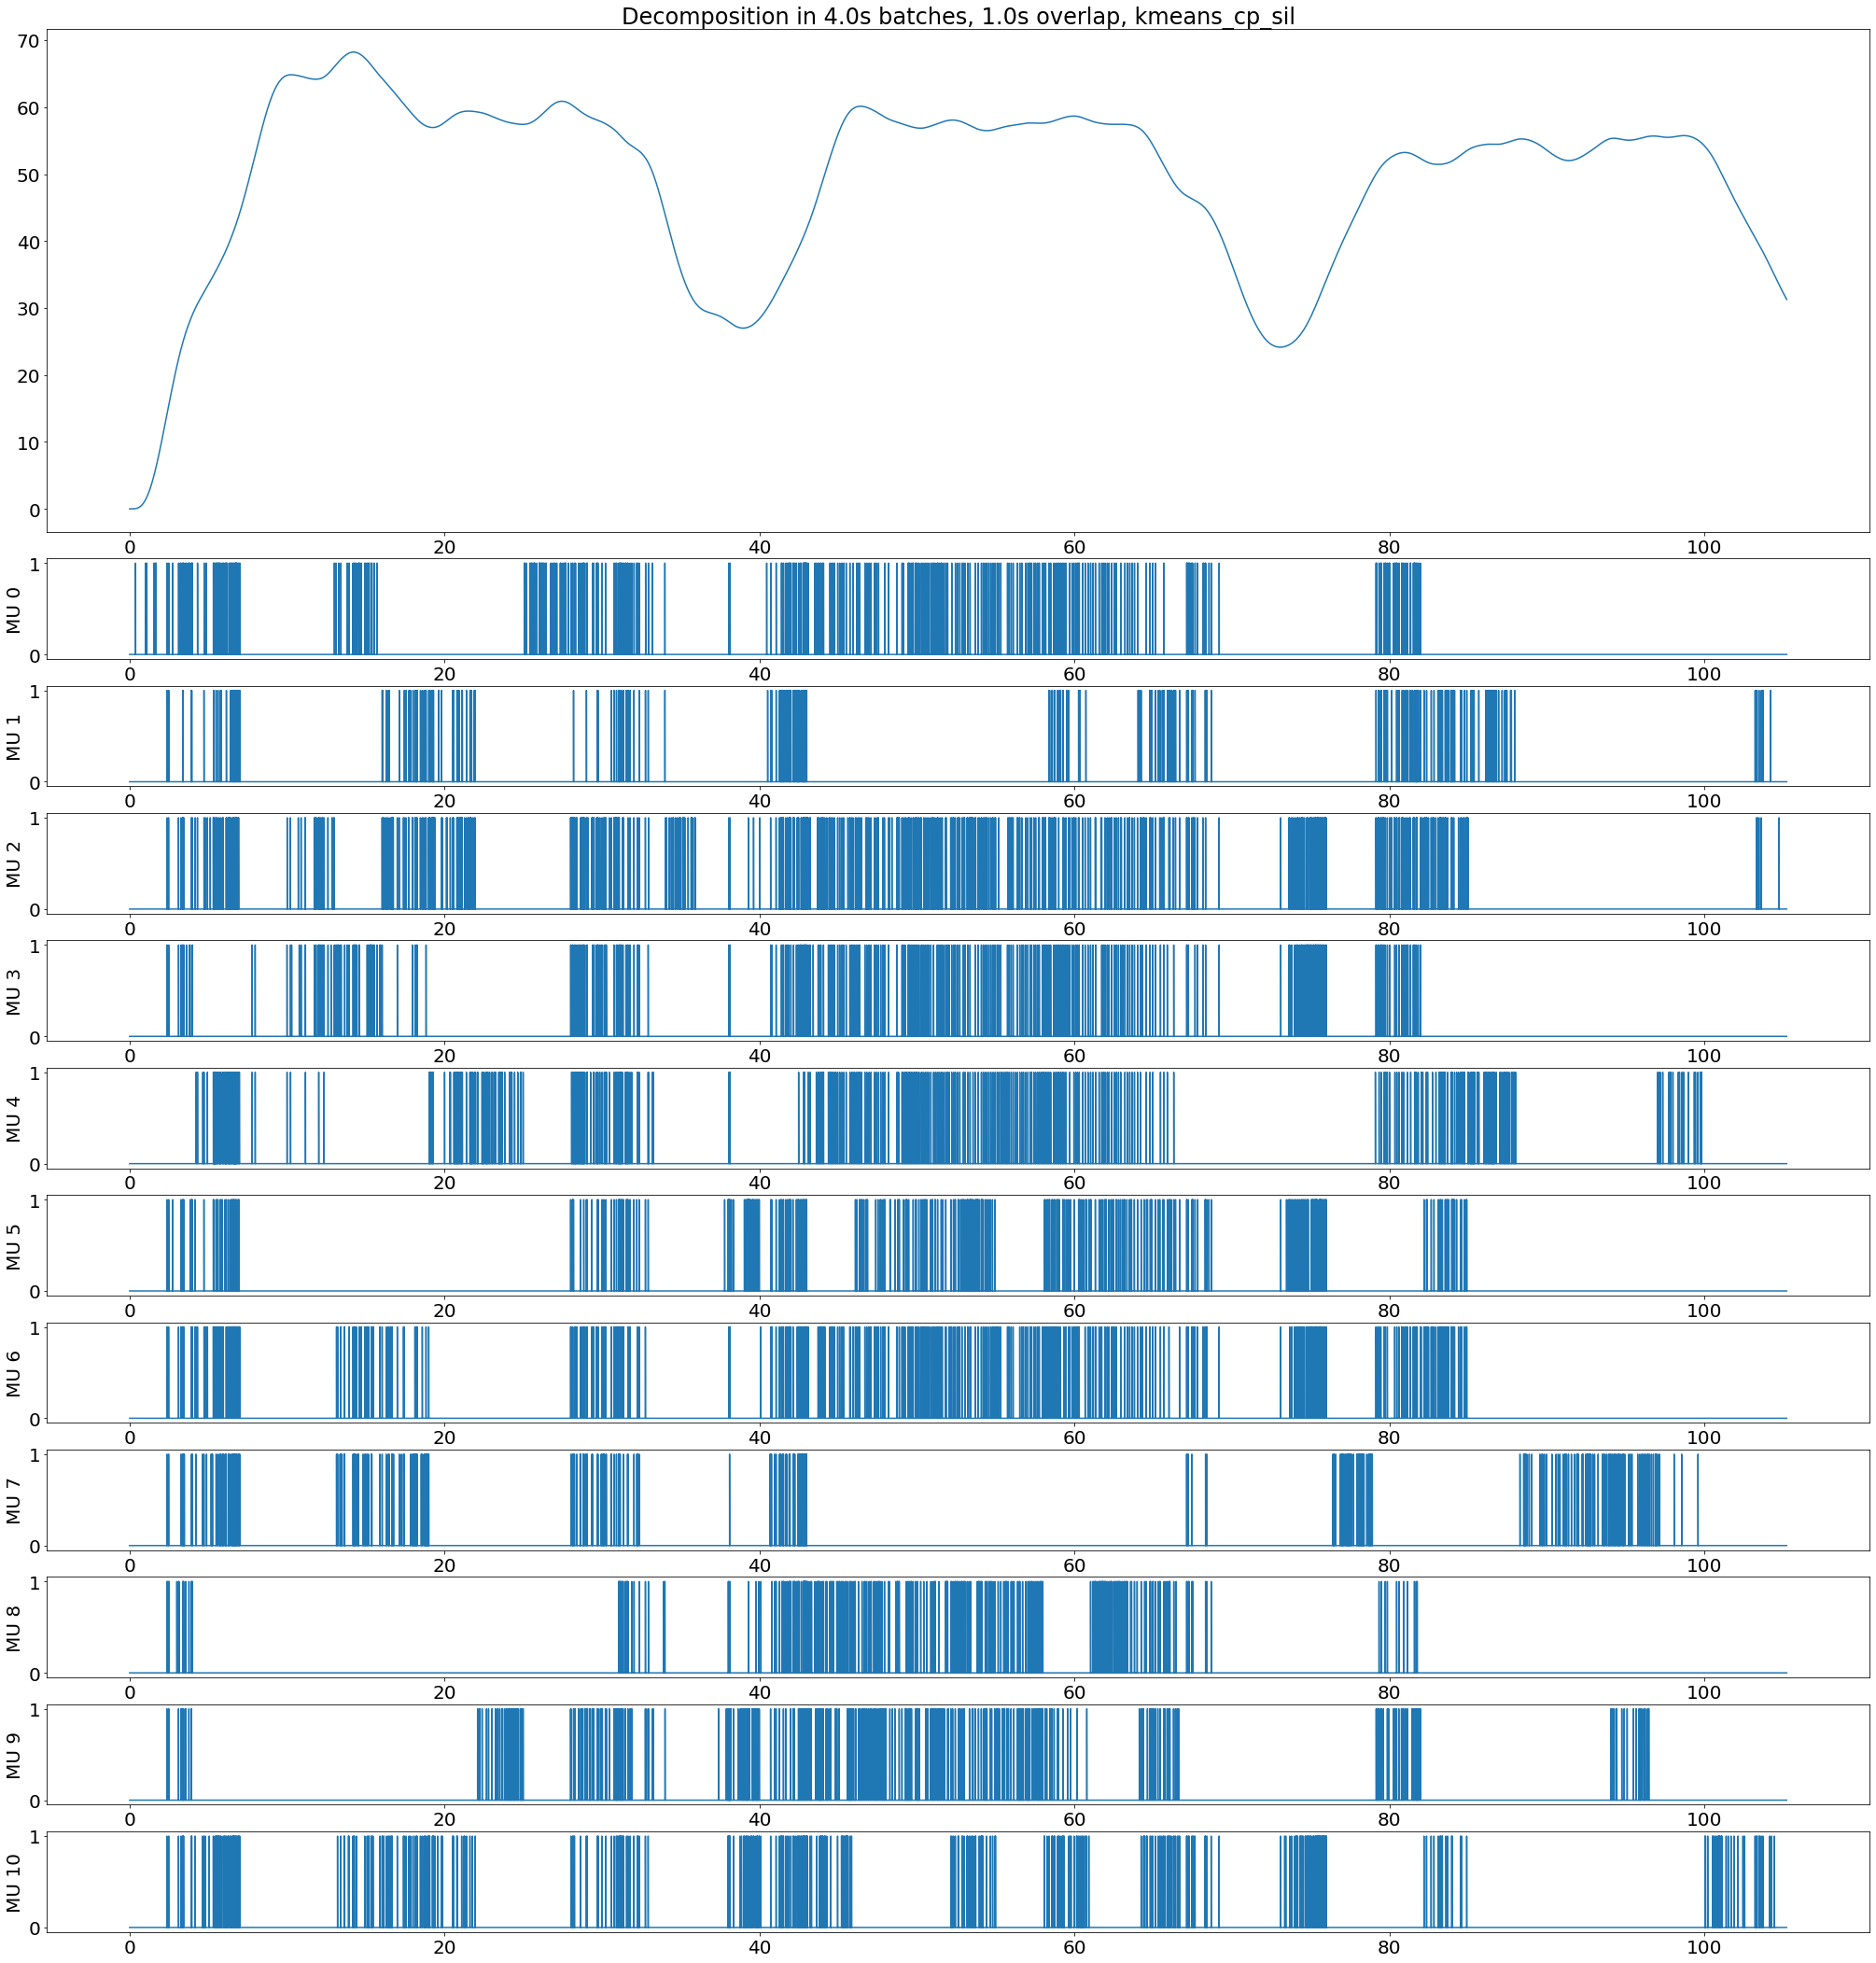

In [22]:
visualize_pt(kmeans_cp_sil_40_ol10["MUPulses"], 
             data, 
             title=f"Decomposition in {batch_size}s batches, {ol[0]}s overlap, kmeans_cp_sil")

### 4.0s, 2.0s overlap

In [23]:
kmeans_cp_sil_40_ol20 = batch_decomp2(data, B_rt, mean_tm, discard = bad_ch, 
                                     use_kmeans=True, thd_noise=0.38, 
                                     classify_mu=True, 
                                     sil_dist=True, 
                                     thd_sil=0.9, 
                                     sc_tm=sc_tm, nc_tm=nc_tm, 
                                     batch_size=batch_size, overlap=ol[1])

In [24]:
roa_kmeans_cp_sil_40_ol20 = calc_roa(ind_pt1=kmeans_cp_sil_40_ol20["MUPulses"], 
                                    ind_pt2=decomp["MUPulses"], 
                                    data=data, 
                                    decomp=f"kmeans_cp_sil {batch_size}s, overlap:{ol[1]}s")

RoA between offline decomposition and kmeans_cp_sil 4.0s, overlap:2.0s (%):
Motor unit 0: 26.004228329809724
Motor unit 1: 0.7058823529411765
Motor unit 2: 16.129032258064516
Motor unit 3: 29.64509394572025
Motor unit 4: 37.08133971291866
Motor unit 5: 6.375227686703097
Motor unit 6: 18.5121107266436
Motor unit 7: 8.83838383838384
Motor unit 8: 16.382978723404257
Motor unit 9: 21.041666666666668
Motor unit 10: 1.5767634854771784
mean: 16.572064338793908


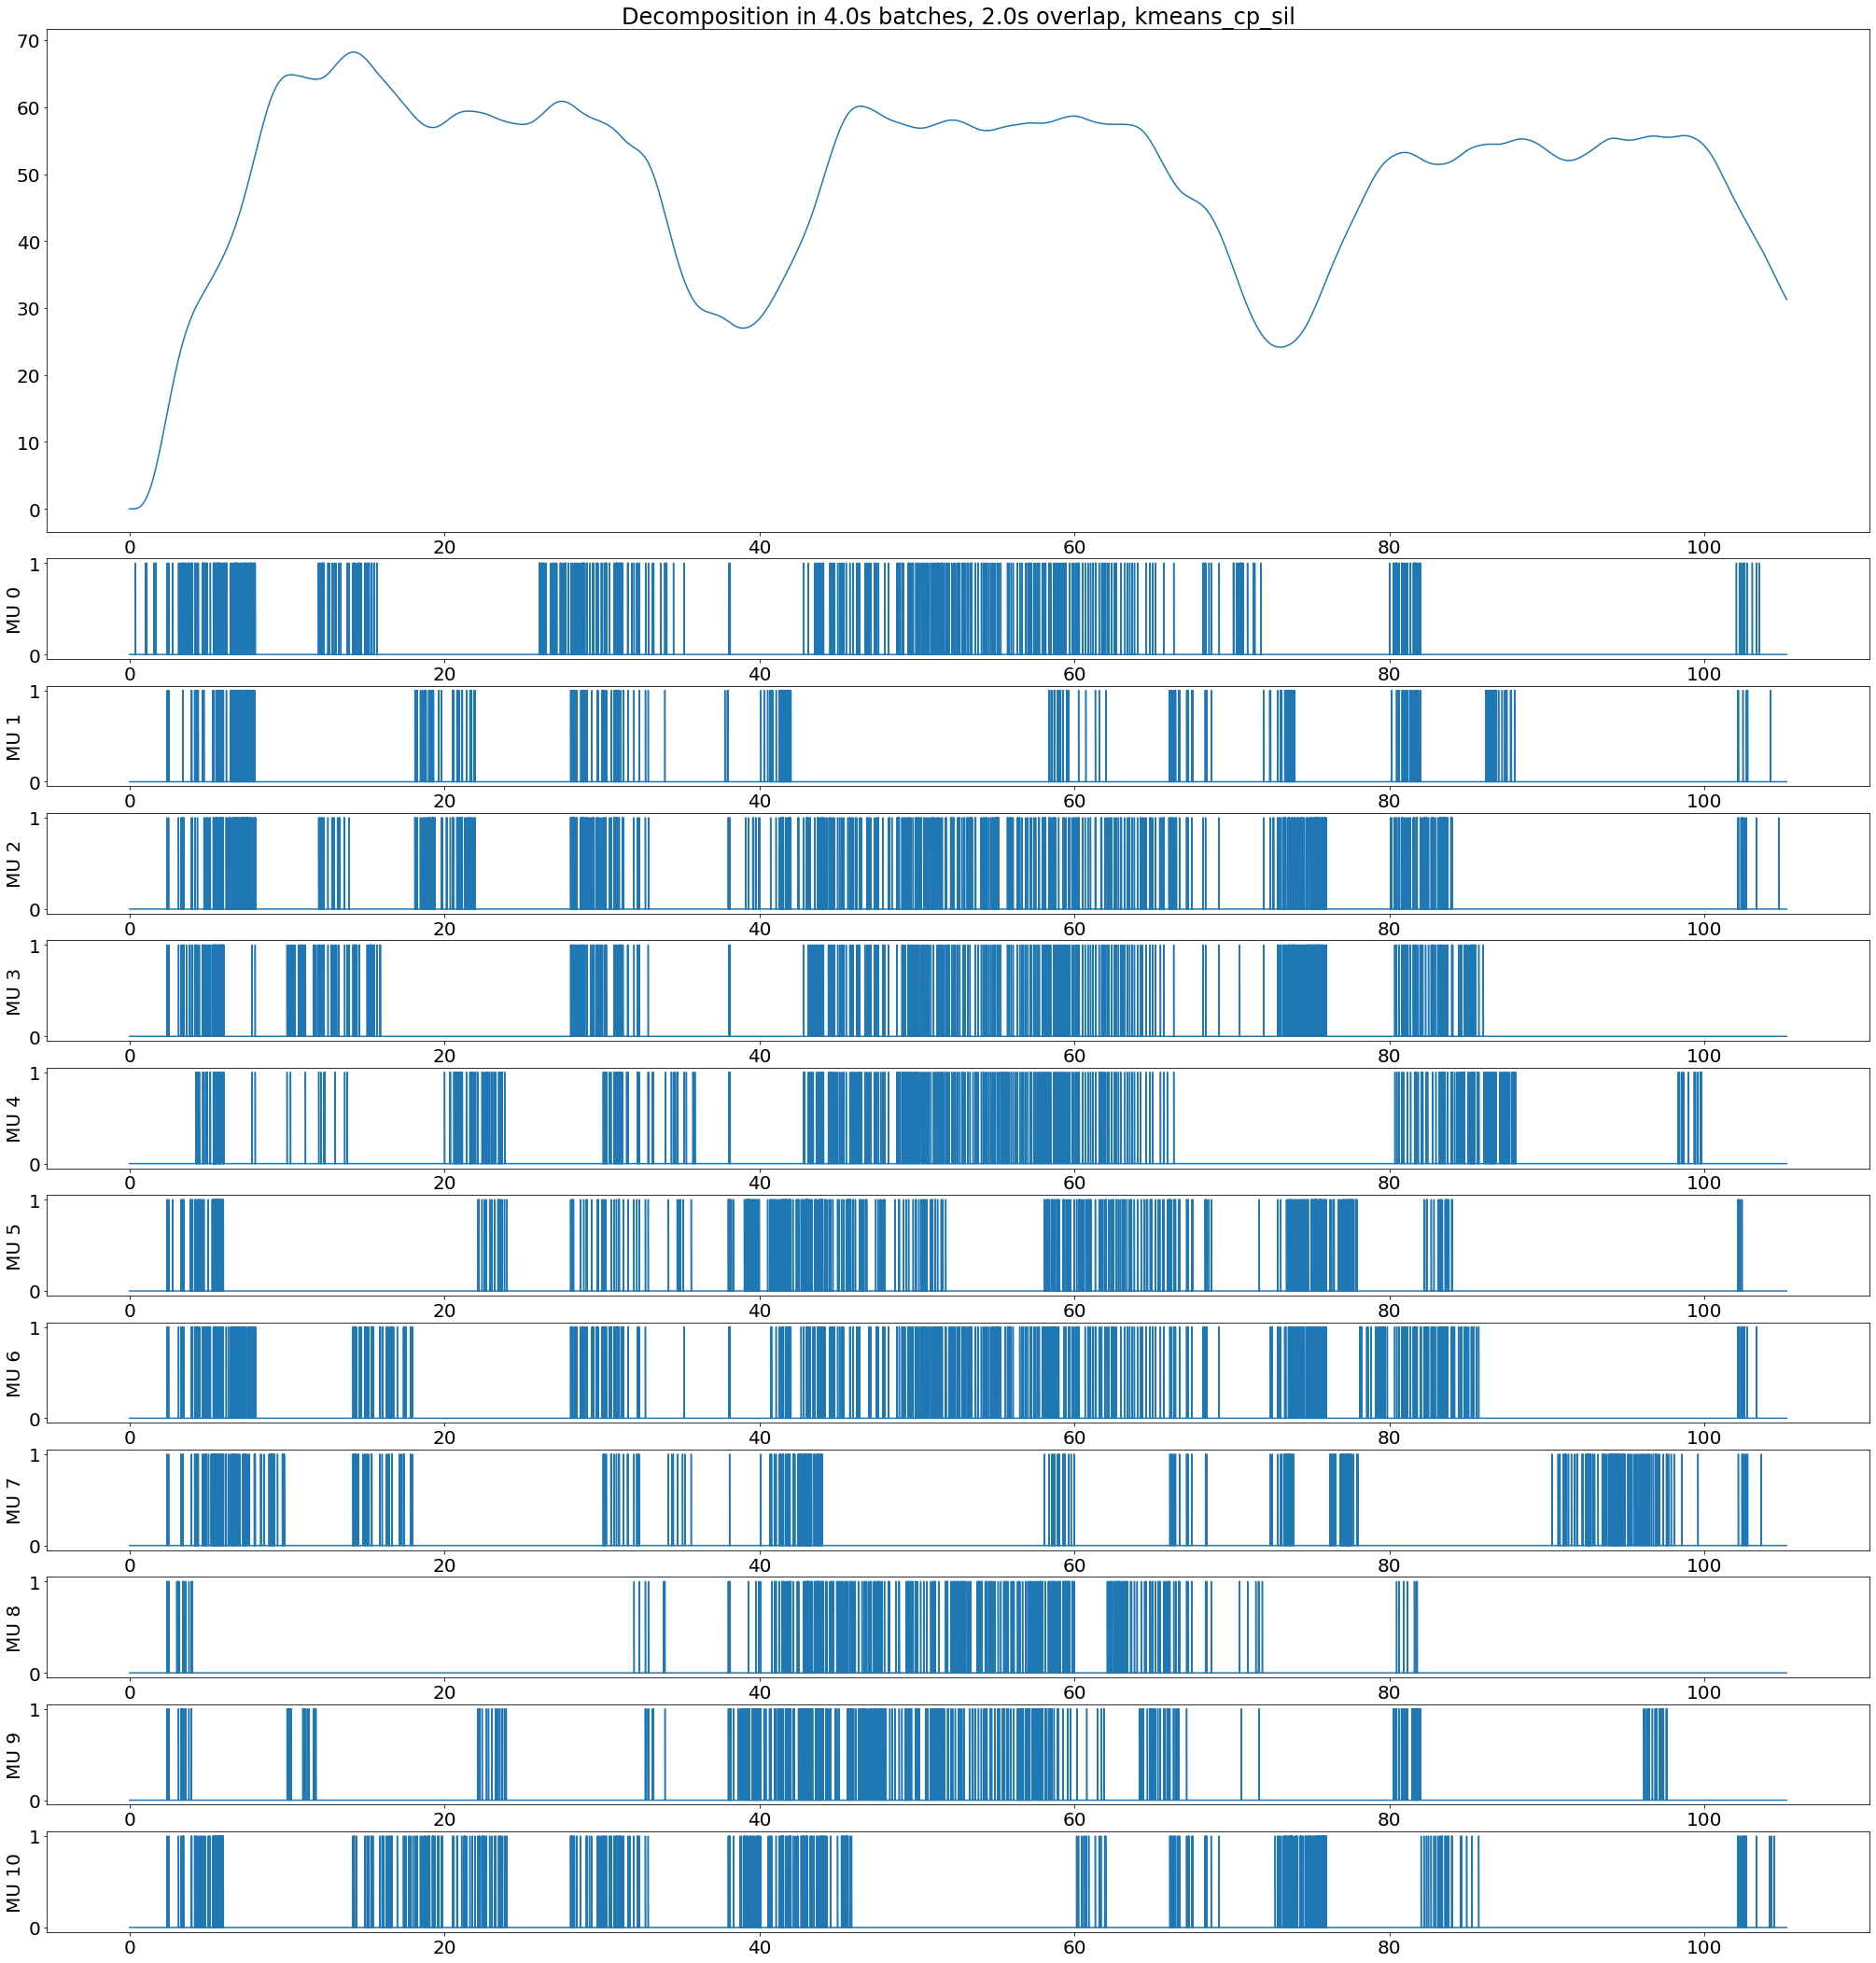

In [25]:
visualize_pt(kmeans_cp_sil_40_ol20["MUPulses"], 
             data, 
             title=f"Decomposition in {batch_size}s batches, {ol[1]}s overlap, kmeans_cp_sil")

### 4.0s, 3.0s overlap

In [26]:
kmeans_cp_sil_40_ol30 = batch_decomp2(data, B_rt, mean_tm, discard = bad_ch, 
                                     use_kmeans=True, thd_noise=0.38, 
                                     classify_mu=True, 
                                     sil_dist=True, 
                                     thd_sil=0.9, 
                                     sc_tm=sc_tm, nc_tm=nc_tm, 
                                     batch_size=batch_size, overlap=ol[2])

In [27]:
roa_kmeans_cp_sil_40_ol30 = calc_roa(ind_pt1=kmeans_cp_sil_40_ol30["MUPulses"], 
                                    ind_pt2=decomp["MUPulses"], 
                                    data=data, 
                                    decomp=f"kmeans_cp_sil {batch_size}s, overlap:{ol[2]}s")

RoA between offline decomposition and kmeans_cp_sil 4.0s, overlap:3.0s (%):
Motor unit 0: 27.522935779816514
Motor unit 1: 0.9411764705882353
Motor unit 2: 15.165165165165165
Motor unit 3: 28.685258964143426
Motor unit 4: 34.68468468468468
Motor unit 5: 6.972477064220183
Motor unit 6: 18.600682593856654
Motor unit 7: 9.022556390977444
Motor unit 8: 14.609053497942387
Motor unit 9: 20.039292730844792
Motor unit 10: 1.5261044176706828
mean: 16.16085343271911


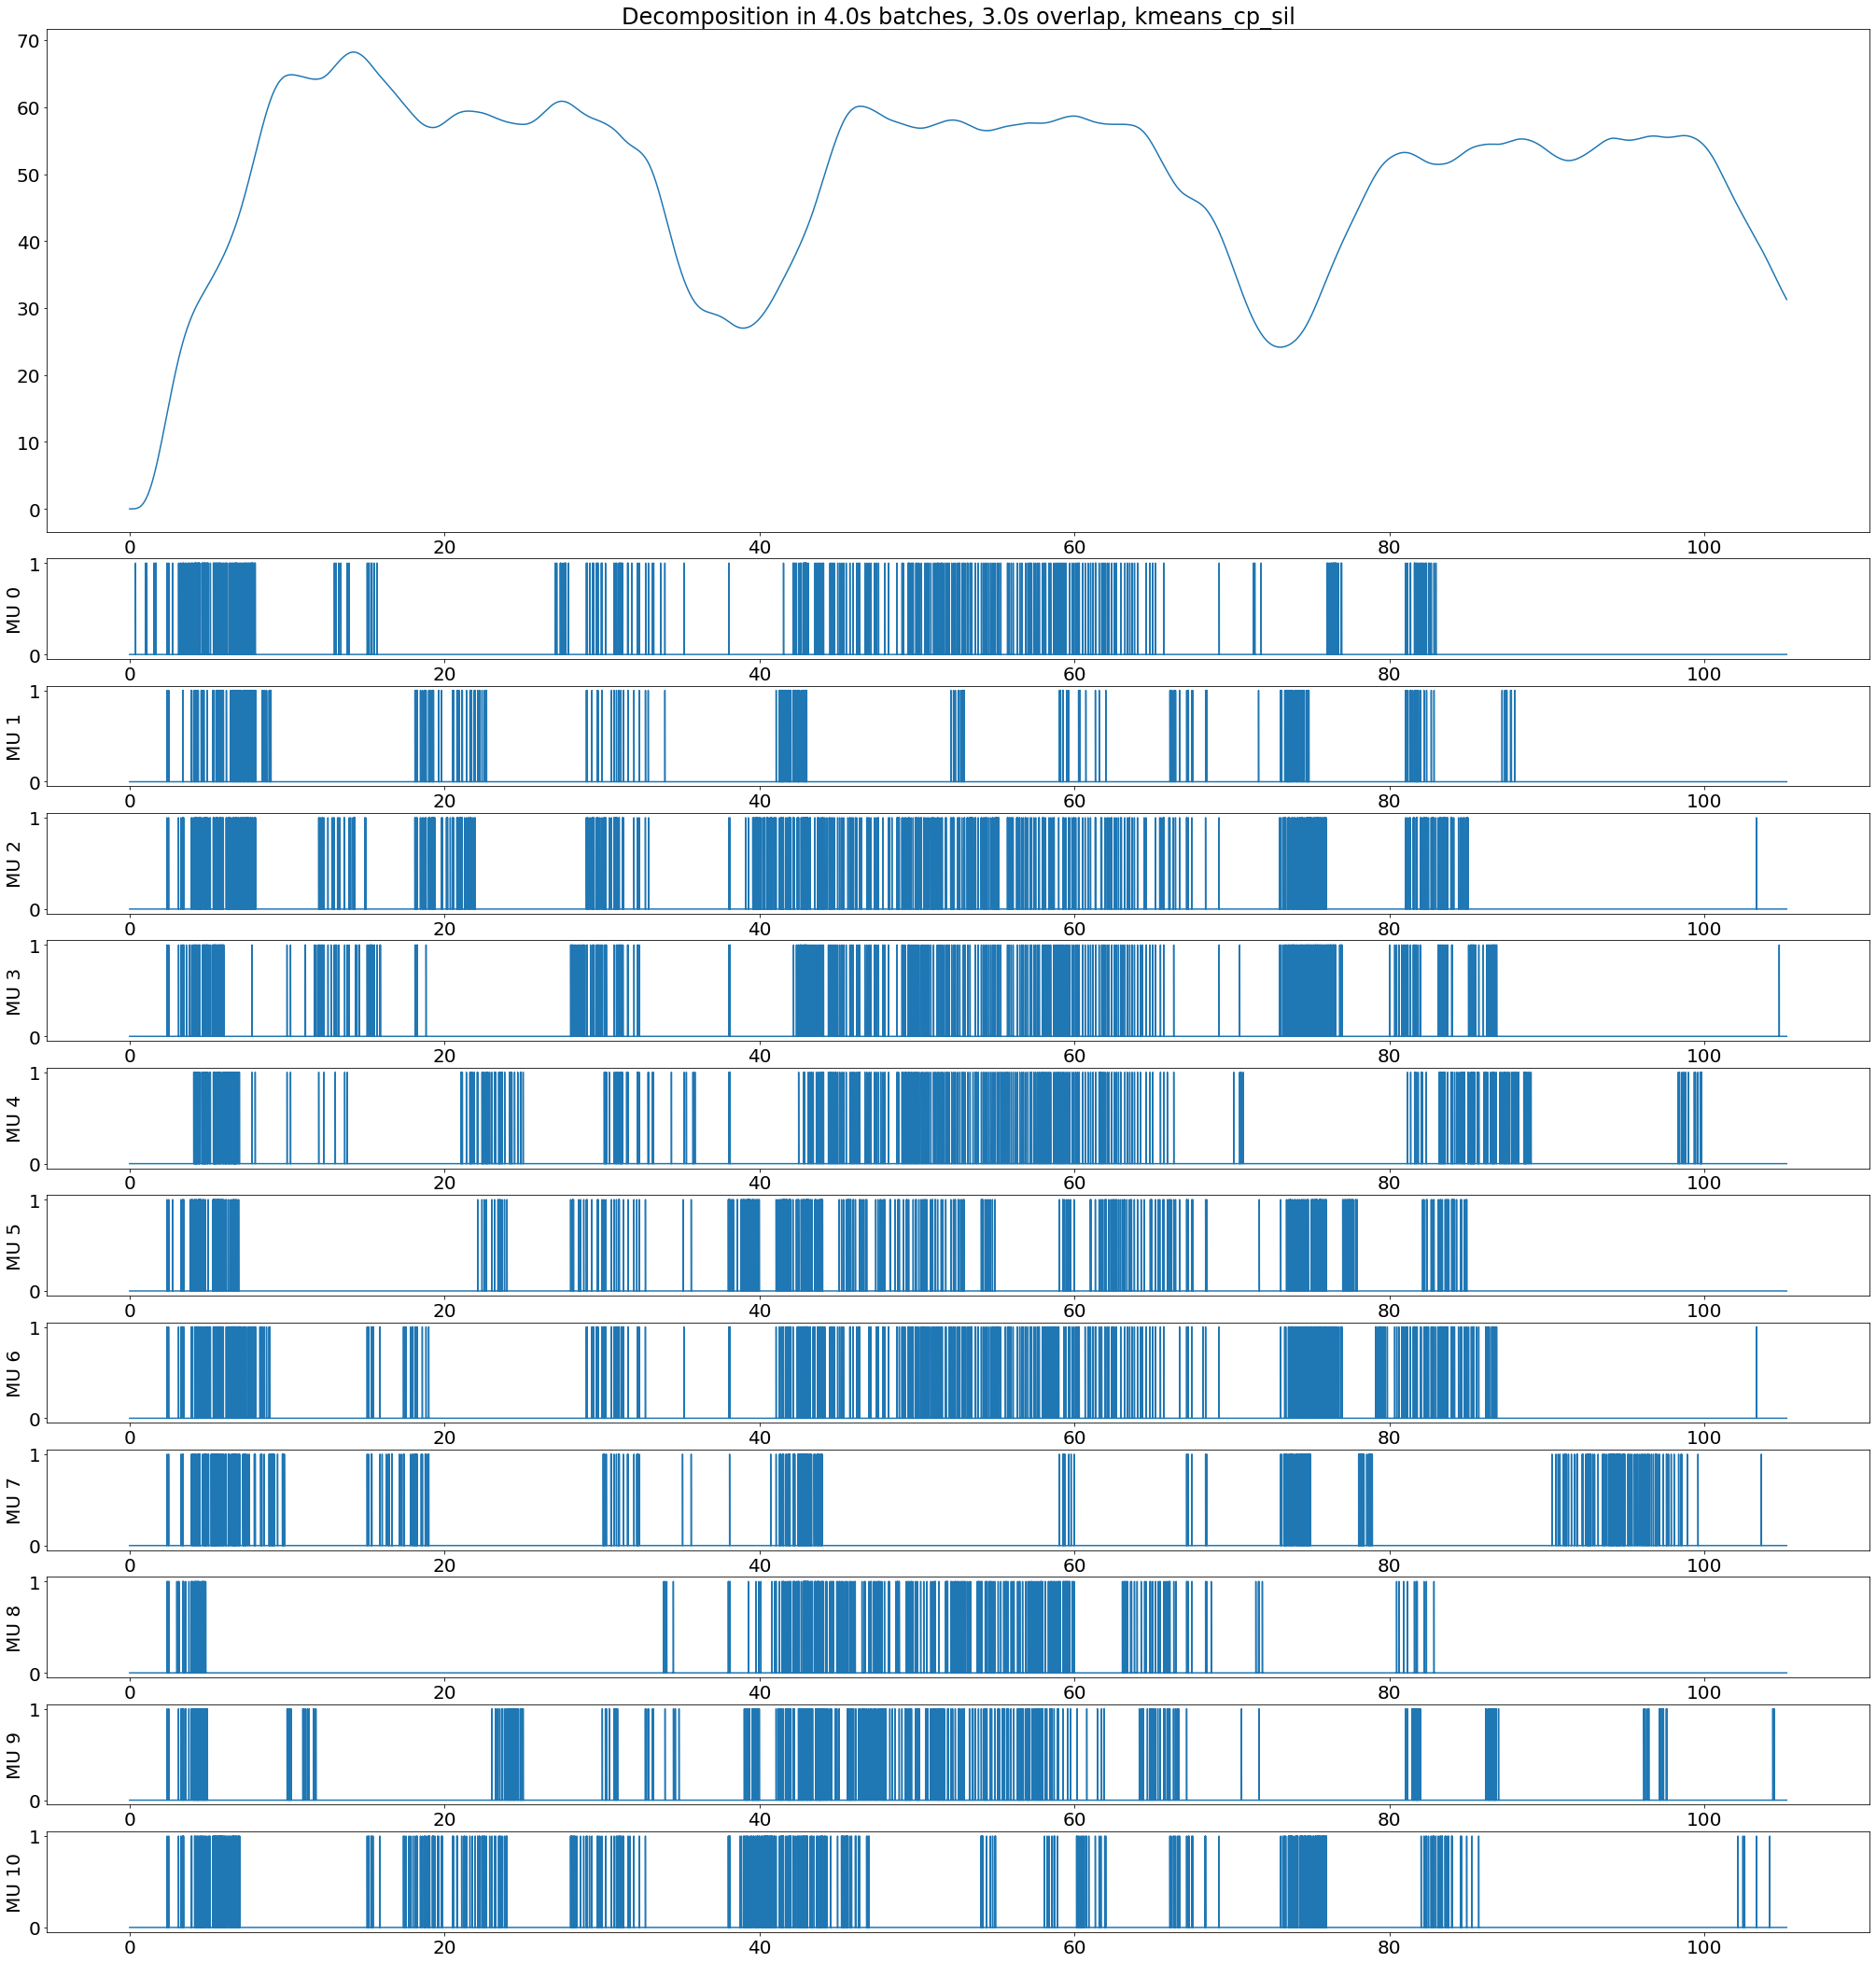

In [28]:
visualize_pt(kmeans_cp_sil_40_ol30["MUPulses"], 
             data, 
             title=f"Decomposition in {batch_size}s batches, {ol[2]}s overlap, kmeans_cp_sil")